In [1]:
library(infercnv)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 



In [2]:
library(rtracklayer)

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



In [3]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ lubridate::%within%() masks IRanges::%within%()
✖ dplyr::collapse()     masks IRanges::collapse()
✖ dplyr::combine()      masks BiocGenerics::combine()
✖ dplyr::desc()         masks IRanges::desc()
✖ tidyr::expand()       masks S4Vectors::expand()
✖ dplyr::filter()       masks stats::filter()
✖ dplyr::first()        masks S4Vectors::first()
✖ dplyr::lag()          masks stats::lag()
✖ ggplot2::Position()   masks BiocGenerics::Position(), base::Position()
✖ purrr::reduce()       masks GenomicRanges::reduce(), IRanges::reduce()
✖ dplyr::rename()       masks S4Vectors::rename()
✖ lubridate::second()   masks S4Vectors::second()
✖ lubridate::second<-

# Prepare files for infercnv

### prepare gene position file (one time only, then read from disk)

#### I downloaded the gtf file from https://support.10xgenomics.com/single-cell-gene-expression/software/release-notes/build#grch38_1.2.0 and filtered as per the instructions there

In [7]:
gtf <- rtracklayer::import('data//Homo_sapiens.GRCh38.84.filtered.gtf')

In [8]:
gtf_df=as.data.frame(gtf)

In [9]:
head(gtf_df)

,seqnames,start,end,width,strand,source,type,score,phase,gene_id,⋯,havana_transcript,havana_transcript_version,tag,transcript_support_level,exon_number,exon_id,exon_version,ccds_id,protein_id,protein_version
,<fct>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<dbl>,<int>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,29554,31109,1556,+,havana,gene,NA,NA,ENSG00000243485,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1,29554,31097,1544,+,havana,transcript,NA,NA,ENSG00000243485,⋯,OTTHUMT00000002840,1,basic,5,NA,NA,NA,NA,NA,NA
3,1,29554,30039,486,+,havana,exon,NA,NA,ENSG00000243485,⋯,OTTHUMT00000002840,1,basic,5,1,ENSE00001947070,1,NA,NA,NA
4,1,30564,30667,104,+,havana,exon,NA,NA,ENSG00000243485,⋯,OTTHUMT00000002840,1,basic,5,2,ENSE00001922571,1,NA,NA,NA
5,1,30976,31097,122,+,havana,exon,NA,NA,ENSG00000243485,⋯,OTTHUMT00000002840,1,basic,5,3,ENSE00001827679,1,NA,NA,NA
6,1,30267,31109,843,+,havana,transcript,NA,NA,ENSG00000243485,⋯,OTTHUMT00000002841,2,basic,5,NA,NA,NA,NA,NA,NA


#### drop duplicate rows -- they're really similar so can just randomly pick one

In [10]:
length(unique((gtf_df %>% filter(type=="gene") %>% select(gene_name, seqnames, start, end))$gene_name))

[1] 33660

In [11]:
nrow(gtf_df %>% filter(type=="gene") %>% select(start, end, source, gene_id, gene_name))

[1] 33694

In [12]:
gtf_df = subset(gtf_df %>% filter(type=="gene") %>% select(gene_name, seqnames, start, end),!duplicated((gtf_df %>% filter(type=="gene"))$gene_name))
nrow(gtf_df)


[1] 33660

#### filter to genes on the 23 chromosomes

In [13]:
gtf_df = gtf_df %>% filter(seqnames %in% c(c(1:22), "X", "Y"))

In [ ]:
write.table(gtf_df, file="data/infercnv_input_files/cd138_mm/gene_pos.txt", col.names=F, row.names=F, quote=F, sep="\t")

#### prepared the other 2 input files in python, writing from anndata object to disk

# Run infercnv

### Run on full data

#### start by running with analysis_mode="subclusters" through step 15 and inspect outputs -- it finds too many subclusters, going to run with analysis_mode="samples" (below)

In [6]:
infercnv_obj_subclusts = CreateInfercnvObject(raw_counts_matrix="data/infercnv_input_files/cd138_mm/counts.txt",
                                    annotations_file="data/infercnv_input_files/cd138_mm/cell_annots.txt",
                                    delim="\t",
                                    gene_order_file="data/infercnv_input_files/cd138_mm/gene_pos.txt",
                                    ref_group_names=c('healthy plasma_NBM-8',
 'healthy plasma_SMM-8',
 'healthy plasma_NBM-4',
 'healthy plasma_MGUS-4',
 'healthy plasma_MGUS-5',
 'healthy plasma_MGUS-1',
 'healthy plasma_NBM-1',
 'healthy plasma_MM-4',
 'healthy plasma_SMM-10',
 'healthy plasma_NBM-7',
 'healthy plasma_SMM-9',
 'healthy plasma_MGUS-3',
 'healthy plasma_NBM-3',
 'healthy plasma_MM-6',
 'healthy plasma_NBM-10',
 'healthy plasma_SMM-3',
 'healthy plasma_NBM-11',
 'healthy plasma_SMM-2',
 'healthy plasma_MM-3',
 'healthy plasma_NBM-6',
 'healthy plasma_MGUS-6',
 'healthy plasma_MGUS-2',
 'healthy plasma_NBM-2'))

INFO [2023-06-21 15:21:13] Parsing matrix: data/infercnv_input_files/cd138_mm/counts.txt
INFO [2023-06-21 15:26:13] Parsing gene order file: data/infercnv_input_files/cd138_mm/gene_pos.txt
INFO [2023-06-21 15:26:13] Parsing cell annotations file: data/infercnv_input_files/cd138_mm/cell_annots.txt
INFO [2023-06-21 15:26:13] ::order_reduce:Start.
INFO [2023-06-21 15:26:18] .order_reduce(): expr and order match.
INFO [2023-06-21 15:26:23] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 22273,29387 Total=325870348 Min=0 Max=23339.
INFO [2023-06-21 15:26:28] num genes removed taking into account provided gene ordering list: 39 = 0.175099896735958% removed.
INFO [2023-06-21 15:26:29] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2023-06-21 15:26:40] Please use "options(scipen = 100)" before running infercnv if you are using the analysis_mode="subclusters" option or you may encounter an error while the hclust is being generated.
INFO [2023

In [7]:
# perform infercnv operations to reveal cnv signal
infercnv_obj_subclusts = infercnv::run(infercnv_obj_subclusts,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                             out_dir="outputs/infercnv/cd138_subclusters/",  # dir is auto-created for storing outputs
                             cluster_by_groups=T,   # cluster
                             denoise=T,
                             HMM=T,
                            analysis_mode='subclusters',
                                       up_to_step=15
                             )

INFO [2023-06-21 15:27:09] ::process_data:Start
INFO [2023-06-21 15:27:09] Checking for saved results.
INFO [2023-06-21 15:27:09] 

	STEP 1: incoming data

INFO [2023-06-21 15:29:12] 

	STEP 02: Removing lowly expressed genes

INFO [2023-06-21 15:29:12] ::above_min_mean_expr_cutoff:Start
INFO [2023-06-21 15:29:13] Removing 18033 genes from matrix as below mean expr threshold: 0.1
INFO [2023-06-21 15:29:14] validating infercnv_obj
INFO [2023-06-21 15:29:14] There are 4201 genes and 29367 cells remaining in the expr matrix.
INFO [2023-06-21 15:29:20] no genes removed due to min cells/gene filter
INFO [2023-06-21 15:30:08] 

	STEP 03: normalization by sequencing depth

INFO [2023-06-21 15:30:08] normalizing counts matrix by depth
INFO [2023-06-21 15:30:11] Computed total sum normalization factor as median libsize: 8455.000000
INFO [2023-06-21 15:30:12] Adding h-spike
INFO [2023-06-21 15:30:12] -hspike modeling of healthy plasma_NBM-8
INFO [2023-06-21 15:31:25] -hspike modeling of healthy 

Centering and scaling data matrix

PC_ 1 
Positive:  FIP1L1, OCIAD2, OCIAD1, COMMD8, TMEM33, UCHL1, RBM47, RHOH, N4BP2, PELI1 
	   AC074289.1, AFTPH, SERTAD2, UGP2, SLC1A4, RAB1A, ACTR2, MDH1, PDS5A, COMMD1 
	   C1D, CCT4, PLEK, GFPT1, NFU1, AAK1, UBE2K, MCPH1, ERICH1, SNRNP27 
Negative:  PFDN5, C12orf10, PCBP2, PRR13, ATP5G2, ITGB7, CALCOCO1, SPRYD3, SMUG1, EIF4B 
	   CBX5, ATG101, HNRNPA1, NR4A1, BIN2, COPZ1, DAZAP2, LETMD1, GTSF1, METTL7A 
	   PIH1D1, CD37, TRPM4, COX14, NCKAP1L, LIN7B, SNRNP70, TMBIM6, BLOC1S1, RUVBL2 
PC_ 2 
Positive:  CUX1, FIS1, ZNHIT1, PLOD3, AP1S1, TRIM56, POP7, GNB2, TSC22D4, PPP1R35 
	   LAMTOR4, COPS6, AZGP1, ZNF655, ZNF394, ATP5J2, CPSF4, BUD31, WDR54, MOGS 
	   PDAP1, MTHFD2, ARPC1B, MOB1A, ARPC1A, BLOC1S6, SQRDL, BOLA3, TRIM69, DUT 
Negative:  SEPT7, HERPUD2, ELMO1, STARD3NL, NT5C3A, RALA, LSM5, GARS, MPLKIP, GGCT 
	   PSMA2, PRR15, MALSU1, TRA2A, NUPL2, MRPL32, TAX1BP1, TOMM7, SKAP2, CTA-293F17.1 
	   STK17A, CBX3, CYCS, TWISTNB, COA1, HNRNPA2B1, DBNL, 

INFO [2023-06-21 16:19:16] define_signif_tumor_subclusters(), tumor: malignant_MGUS-3


Centering and scaling data matrix

PC_ 1 
Positive:  IGHG3, IGHG1, IGHD, IGHA1, AL928768.3, IGHGP, IGHM, IGHG2, KIAA0125, IGHV2-5 
	   IGHG4, IGHV3-7, CH17-224D4.2, IGHV3-11, IGHE, IGHV3-15, IGHV1-18, IGHV3-20, IGHA2, IGHV3-21 
	   IGHV3-23, IGHV1-24, IGHV3-30, CRIP1, IGHV3-33, IGHV4-34, IGHV4-39, SIVA1, IGHV3-43, C14orf2 
Negative:  S100A6, S100A8, S100A4, S100A9, S100A11, THEM4, S100A10, PRPF4B, MRPL9, CHTOP 
	   PSMG4, NQO2, POGZ, SERPINB6, ECI2, PSMB4, VPS72, SCNM1, LYRM4, SERPINB1 
	   CDC42SE1, PSMD4, SNAPIN, LY86, C1orf56, GMDS, SSR1, TXNDC5, ILF2, IRF4 
PC_ 2 
Positive:  ARL2BP, POLR2C, CNOT1, CKLF, FAM192A, DYNC1LI2, NAE1, HERPUD1, FAM96B, MT1X 
	   TRADD, NOL3, TMEM208, MT1F, ATP6V0D1, CENPT, MT2A, NUTF2, NUDT21, PSMB10 
	   CHD9, NFATC3, CHTF8, CYLD, VPS4A, NOB1, LONP2, AARS, DDX19B, PHKB 
Negative:  OTUD6B-AS1, TMEM55A, NDUFAF6, DECR1, NBN, CPNE3, TP53INP1, C8orf59, PLEKHF2, ZFAND1 
	   UQCRB, FABP5, TPD52, PTDSS1, PEX2, CPQ, LY96, TMEM70, TCEB1, RPL7 
	   MTDH, TERF1, LACT

INFO [2023-06-21 16:19:17] define_signif_tumor_subclusters(), tumor: malignant_MGUS-6


Centering and scaling data matrix

PC_ 1 
Positive:  HAT1, ITGA6, AC078883.3, DYNC1I2, AC093818.1, PDK1, METTL8, SP3, OLA1, CIR1 
	   TLK1, GPR155, GORASP2, ORMDL1, ASNSD1, WIPF1, ZC3H15, FRZB, DNAJC10, C2orf88 
	   ATP5G3, ITGA4, METTL5, UBE2E3, MTX2, HNRNPA3, HIBCH, PLEKHA3, PRKRA, NFE2L2 
Negative:  RPL27A, RIC3, TMEM9B, EIF3F, MRPL17, TMEM41B, TPP1, IPO7, TAF10, ADM 
	   EIF4G2, ILK, ZBED5, ZBED5-AS1, TIMM10B, COPB1, PSMA1, ARFIP2, C11orf58, SMPD1 
	   RPS13, HBD, PIK3C2A, HBB, NUCB2, RHOG, SERGEF, CARS, NAP1L4, KCNQ1OT1 
PC_ 2 
Positive:  PFDN4, RTFDC1, ZBP1, TSHZ2, DPM1, PMEPA1, PTPN1, GNAS, CEBPB, NELFCD 
	   RNF114, SULF2, NCOA3, STAU1, ZMYND8, DDX27, ZFAS1, SLC35C2, CTSZ, CD40 
	   PCIF1, PLTP, CTSA, ATP5E, PIGT, SYS1, PRELID3B, STK4, YWHAB, ADA 
Negative:  SDHC, FCGR2B, PFDN2, NDUFS2, TSTD1, LY9, UFC1, B4GALT3, SLAMF7, FCRLA 
	   DUSP12, CD48, ATF6, SLAMF1, UAP1, NCSTN, COPA, MGST3, DCAF8, IGSF8 
	   ALDH9A1, TAGLN2, TMCO1, DUSP23, AIM2, IFI16, POU2F1, CD1D, FCRL2, CREG1 
PC_

INFO [2023-06-21 16:19:17] define_signif_tumor_subclusters(), tumor: malignant_MM-1


Centering and scaling data matrix

PC_ 1 
Positive:  PIM2, OTUD5, PQBP1, WDR45, TIMM17B, PLP2, WAS, MAGED1, PAPOLA, RP11-1070N10.3 
	   IFI27L2, YY1, WDR13, TSPYL2, WARS, HSD17B10, RBM3, HUWE1, PPP2R5C, EBP 
	   MAGED2, FTSJ1, MAGEH1, DYNC1H1, LINC01420, SLC38A5, MSN, YIPF6, HSP90AA1, UXT 
Negative:  PNPLA8, DNAJB9, THAP5, IMMP2L, HBP1, IFRD1, LINC00998, NAMPT, TES, SYPL1 
	   CAV1, SRPK2, CAPZA2, LSM8, KMT2E, FAM3C, KMT2E-AS1, CADPS2, PSMC2, NDUFA5 
	   DNAJC2, PMPCB, ZNF800, POLR2J3, ARF5, POLR2J, SND1, LRWD1, ORAI2, SND1-IT1 
PC_ 2 
Positive:  H2AFJ, ATF7IP, GPRC5D, WBP11, CDKN1B, CREBL2, SMIM10L1, ARHGDIB, PRR4, STRAP 
	   MAGOHB, GABARAPL1, DERA, TMEM52B, GOLT1B, CLEC2B, LDHB, CLECL1, CMAS, M6PR 
	   ETNK1, NECAP1, EMG1, LRMP, PHB2, LYRM5, PTPN6, C12orf57, KRAS, TPI1 
Negative:  TNFSF10, FNDC3B, TBL1XR1, RPL22L1, ACTL6A, SKIL, PHC3, MRPL47, NDUFB5, GPR160 
	   TTC14, SEC62, FXR1, GOLIM4, DNAJC19, ATP11B, PDCD10, NMD3, DCUN1D1, SMC4 
	   KLHL6, MFSD1, KLHL24, RSRC1, PARL, CCNL1, EI

INFO [2023-06-21 16:19:24] define_signif_tumor_subclusters(), tumor: malignant_MM-2


Centering and scaling data matrix

PC_ 1 
Positive:  ARL2BP, POLR2C, FAM192A, MT1X, CNOT1, HERPUD1, MT1F, MT2A, CKLF, DYNC1LI2 
	   NUDT21, NAE1, FAM96B, TRADD, NOL3, TMEM208, ATP6V0D1, CENPT, NUTF2, PSMB10 
	   NFATC3, METTL10, OAT, UROS, CHST15, BCCIP, MGMT, GLRX3, BNIP3, BUB3 
Negative:  FAU, TM7SF2, SYVN1, VPS51, CAPN1, ZFPL1, ARL2, DPF2, SF1, SLC25A45 
	   PRDX5, TRMT112, NEAT1, CMB9-22P13.1, ESRRA, MALAT1, SCYL1, LTBP3, BAD, SSSCA1 
	   KAT5, RNASEH2C, PPP1R14B, CFL1, FKBP2, CTSW, FIBP, DNAJC4, CCDC85B, DRAP1 
PC_ 2 
Positive:  RPL23A, TP53I13, SDF2, NSRP1, POLDIP2, IFT20, TP53INP1, NDUFAF6, PLEKHF2, OTUD6B-AS1 
	   TMEM55A, UQCRB, NBN, WSB1, DECR1, CPNE3, PTDSS1, MAP2K3, CPQ, TMEM11 
	   MTDH, USP22, RPL30, B9D1, RP11-160E2.6, RPL41, COX6C, MYL6B, PA2G4, MYL6 
Negative:  PDCD10, GOLIM4, NMD3, SEC62, SMC4, MFSD1, GPR160, RSRC1, PHC3, SKIL 
	   CCNL1, RPL22L1, TIPARP, FNDC3B, SSR3, TNFSF10, SLC33A1, DHX36, TBL1XR1, MBNL1 
	   ACTL6A, SELT, MRPL47, EIF2A, NDUFB5, SERP1, RNF13, COMM

INFO [2023-06-21 16:19:32] define_signif_tumor_subclusters(), tumor: malignant_MM-3


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, RPS11, ALDH16A1, FCGRT, PIH1D1, NOSIP, CD37, IRF3, EEF2, MAP2K2 
	   MRPL54, UBXN6, TRPM4, HMG20B, SAFB2, BCL2L12, MYDGF, SAFB, NFIC, RPL36 
	   LIN7B, NCLN, PRMT1, S1PR4, AES, PTOV1, SNRNP70, C19orf70, SGTA, PNKP 
Negative:  IGHA2, IGHE, CRIP1, IGHG4, IGHG2, SIVA1, AL928768.3, IGHGP, IGHA1, C14orf2 
	   APOPT1, IGHG1, MARK3, EIF5, IGHG3, CINP, HSP90AA1, DYNC1H1, PPP2R5C, IGHD 
	   WARS, YY1, IGHM, PAPOLA, RP11-1070N10.3, IFI27L2, KIAA0125, IFI27, IGHV2-5, IFI27L1 
PC_ 2 
Positive:  APOBEC3G, APOBEC3C, SGSM3, CBX7, TNRC6B, ST13, RPS19BP1, CBX6, RPL3, RBX1 
	   ATF4, SYNGR1, PHF5A, TOMM22, ACO2, POLR3H, DDX17, DESI1, XRCC6, KDELR3 
	   SNU13, CSNK1E, MEI1, TNFRSF13C, SMDT1, POLR2F, NDUFA6, RRP7A, RNU12, EIF3L 
Negative:  PARP14, PARP9, PDIA5, FAM162A, ZNF148, EAF2, IQCB1, TPRA1, PODXL2, GOLGB1 
	   SEC61A1, RUVBL1, HCLS1, RPN1, NDUFB4, RAB7A, LRRC58, CNBP, COX17, COPG1 
	   HMCES, TIMMDC1, H1FX, TMEM39A, MBD4, NUDT16, B4GALT4,

INFO [2023-06-21 16:19:34] define_signif_tumor_subclusters(), tumor: malignant_MM-4


Centering and scaling data matrix

PC_ 1 
Positive:  BST2, BISPR, RPL18A, MVB12A, CCDC124, JUND, DDA1, PGLS, LSM4, MRPL34 
	   BABAM1, PGPEP1, OCEL1, SSBP4, ELL, USE1, FKBP8, SMIM7, KXD1, UBA52 
	   SLC35E1, C19orf60, KLF2, FAM32A, COPE, HSH2D, TMEM160, AP2S1, SUGP2, SLC1A5 
Negative:  NAAA, SDAD1, USO1, G3BP2, SCARB2, PARM1, CCNI, AREG, MRPL1, MTHFD2L 
	   HNRNPD, RASSF6, HNRNPDL, COX18, ENOPH1, SEC31A, COPS4, PLAC8, GRSF1, MRPS18C 
	   HSD17B11, PPM1K, HERC5, SPP1, PYURF, NUDT9, JCHAIN, FAM13A, UGT2B17, EIF4E 
PC_ 2 
Positive:  TIMM13, GADD45B, LSM7, GNG7, SLC39A3, OAZ1, SGTA, AES, JSRP1, S1PR4 
	   PLEKHJ1, NCLN, AP3D1, MOB3A, NFIC, MKNK2, HMG20B, MRPL54, ABHD17A, TCF3 
	   EEF2, MAP2K2, UQCR11, UBXN6, MYDGF, C19orf25, SAFB2, SAFB, RPS15, RPL36 
Negative:  PIGF, RHOQ, CRIPT, PPM1B, MCFD2, ZFP36L2, CALM2, COX7A2L, CHAC2, ERLEC1 
	   EML4, ACYP2, AC007246.3, SPTBN1, RTN4, SRSF7, QPCT, PRKD3, CEBPZ, RPS27A 
	   CEBPZOS, EIF2AK2, CCDC88A, FAM98A, PPP4R3B, BCL11A, RASGRP3, C2orf74, USP34

INFO [2023-06-21 16:19:35] define_signif_tumor_subclusters(), tumor: malignant_MM-5


Centering and scaling data matrix

PC_ 1 
Positive:  CSNK1E, POLR2F, KDELR3, DDX17, TOMM22, EIF3L, CBX6, LGALS1, APOBEC3C, APOBEC3G 
	   GGA1, CBX7, MFNG, RPL3, CYTH4, SYNGR1, RAC2, ATF4, MPST, RPS19BP1 
	   NCF4, TNRC6B, IFT27, SGSM3, EIF3D, ST13, RBX1, TXN2, PHF5A, APOL1 
Negative:  TPT1, GTF2F2, ZC3H13, DNAJC15, LCP1, EPSTI1, RGCC, ESD, MED4, ELF1 
	   ITM2B, MRPS31, RB1, NHLRC3, RCBTB2, UFM1, FNDC3A, EXOSC8, PHF11, ALG5 
	   EBPL, SPG20, RNASEH2B, N4BP2L2, INTS6, PIGBOS1, CCPG1, C15orf65, RAB27A, ZNF280D 
PC_ 2 
Positive:  HNRNPA3, MTX2, NFE2L2, PRKRA, ATP5G3, PLEKHA3, WIPF1, GPR155, UBE2E3, ITGA4 
	   CIR1, DNAJC10, OLA1, SP3, FRZB, PDK1, ZC3H15, AC093818.1, ASNSD1, AC078883.3 
	   ORMDL1, ITGA6, C2orf88, HAT1, HIBCH, DYNC1I2, GLS, STAT1, METTL8, NABP1 
Negative:  RPS9, LENG8, LILRB1, TSEN34, LILRB4, HSPBP1, BRSK1, LENG1, RPL28, CNOT3 
	   UBE2S, PRPF31, ISOC2, NDUFA3, MYADM, ZNF524, ZNF331, ZNF580, PPP2R1A, ETFB 
	   ZNF581, C19orf48, U2AF2, EPN1, JOSD2, CTC-444N24.11, TRAPPC2P1,

INFO [2023-06-21 16:19:37] define_signif_tumor_subclusters(), tumor: malignant_MM-6


Centering and scaling data matrix

PC_ 1 
Positive:  SETX, RPL7A, SURF1, SURF2, SURF4, MRPL54, HMG20B, NFIC, EEF2, REXO4 
	   NCLN, S1PR4, AES, SGTA, MAP2K2, SLC39A3, MRPS2, GNG7, UBXN6, GADD45B 
	   TIMM13, MYDGF, PMPCA, LSM7, OAZ1, SNHG7, SAFB2, JSRP1, TMEM141, SAFB 
Negative:  IGHV3-74, IGHV1-69-2, IGHV4-61, IGHV4-59, IGHV5-51, IGHV3-48, IGHV3-43, IGHV4-39, IGHV4-34, IGHV3-33 
	   IGHV3-30, IGHV1-24, IGHV3-23, IGHV3-21, IGHV3-20, IGHV1-18, IGHV3-15, IGHV3-11, CH17-224D4.2, IGHV3-7 
	   IGHV2-5, KIAA0125, IGHM, IGHD, IGHG3, IGHG1, IGHA1, AL928768.3, IGHGP, IGKV2-28 
PC_ 2 
Positive:  CCNL1, RSRC1, TIPARP, MFSD1, SSR3, SLC33A1, DHX36, MBNL1, SMC4, SELT 
	   RNF13, COMMD2, SERP1, EIF2A, GYG1, XRN1, U2SURP, NMD3, TFDP2, PDCD10 
	   ATP1B3, RNF7, GOLIM4, RASA2, ZBTB38, SEC62, SLC25A36, COPB2, GPR160, MRPS22 
Negative:  RPS26, PA2G4, PYM1, RPL41, ORMDL2, MYL6B, CD63, MYL6, BLOC1S1, NABP2 
	   NCKAP1L, CNPY2, GTSF1, BAZ2A, COPZ1, ATP5B, HNRNPA1, CBX5, PTGES3, SMUG1 
	   CALCOCO1, ATP5G2, N

INFO [2023-06-21 16:19:39] define_signif_tumor_subclusters(), tumor: malignant_MM-7


Centering and scaling data matrix

PC_ 1 
Positive:  PPP1R15A, RPL18, NUCB1, BAX, FTL, CYTH2, RUVBL2, SNRNP70, KDELR1, LIN7B 
	   TRPM4, EMP3, CD37, PIH1D1, CARD8, ALDH16A1, RPL13A, SEPW1, RPS11, GLTSCR2 
	   FCGRT, NOSIP, NAPA, IRF3, NAPA-AS1, BCL2L12, PRMT1, BBC3, PTOV1, TMEM160 
Negative:  SPPL2A, USP8, ARPP19, GABPB1-AS1, FAM214A, GABPB1, RSL24D1, RAB27A, DTWD1, PIGBOS1 
	   GALK2, CCPG1, C15orf65, ZNF280D, COPS2, ADAM10, FAM63B, SECISBP2L, SLTM, GTF2A2 
	   EID1, BNIP2, ANXA2, ICE2, RORA, DUT, VPS13C, SQRDL, RPS27L, APH1B 
PC_ 2 
Positive:  FGFR1OP2, SSPN, TM7SF3, BHLHE41, MRPS35, CD79A, RPS19, ARHGEF1, AC006129.2, CCDC91 
	   RP11-707G18.1, LINC01480, ATP5SL, RABAC1, ERGIC2, POU2F2, EXOSC5, KRAS, DEDD2, TGFB1 
	   FAM60A, LYRM5, HNRNPUL1, PAFAH1B3, DENND5B, SNRPA, LTBP4, KIAA1551, ETHE1, LRMP 
Negative:  ATP1A1, MAN1A2, SIKE1, FAM46C, CSDE1, AMPD1, TRIM33, BCAS2, PHGDH, RSBN1 
	   CAPZA1, SEC22B, RAP1A, CH17-373J23.1, ATP5F1, RNF115, DRAM2, RBM8A, LRIF1, CD53 
	   POLR3GL, KCNA3,

INFO [2023-06-21 16:19:39] define_signif_tumor_subclusters(), tumor: malignant_MM-8


Centering and scaling data matrix

PC_ 1 
Positive:  NMD3, SMC4, MFSD1, PDCD10, SEC62, RSRC1, GOLIM4, GPR160, CCNL1, SSR3 
	   TIPARP, DHX36, SLC33A1, MBNL1, PHC3, SELT, SKIL, EIF2A, SERP1, RNF13 
	   COMMD2, GYG1, RPL22L1, U2SURP, XRN1, FNDC3B, TFDP2, TNFSF10, ATP1B3, TBL1XR1 
Negative:  LAMTOR3, DNAJB14, DAPP1, ADH5, H2AFZ, EIF4E, FAM13A, PPP3CA, PYURF, FLJ20021 
	   HERC5, PPM1K, SLC39A8, SPP1, UBE2D3, CISD2, NUDT9, PPA2, HSD17B11, AIMP1 
	   PAPSS1, MRPS18C, RPL34, PLAC8, OSTC, CCDC109B, COPS4, PLA2G12A, SEC31A, GAR1 
PC_ 2 
Positive:  GARS, LSM5, GGCT, NT5C3A, HERPUD2, PRR15, SEPT7, TAX1BP1, ELMO1, SKAP2 
	   STARD3NL, CBX3, RALA, HNRNPA2B1, MPLKIP, CYCS, TRA2A, PSMA2, MALSU1, NUPL2 
	   MRPL32, TOMM7, STK17A, CTA-293F17.1, TWISTNB, HDAC9, COA1, TSPAN13, ARL4A, DBNL 
Negative:  SLC50A1, DPM3, KRTCAP2, FLAD1, MTX1, CKS1B, SCAMP3, SHC1, FDPS, PBXIP1 
	   ASH1L, DAP3, PMVK, GON4L, KCNN3, KIAA0907, ADAR, ARHGEF2, SSR2, IL6R 
	   LAMTOR2, HAX1, LMNA, C1orf43, SEMA4A, PMF1, TPM3, GLMP, 

INFO [2023-06-21 16:19:40] define_signif_tumor_subclusters(), tumor: malignant_SMM-1


Centering and scaling data matrix

PC_ 1 
Positive:  G3BP2, PARM1, USO1, AREG, NAAA, MTHFD2L, SDAD1, RASSF6, SCARB2, CCNI 
	   COX18, GRSF1, MRPL1, HNRNPD, HNRNPDL, JCHAIN, ENOPH1, SEC31A, UGT2B17, COPS4 
	   PLAC8, YTHDC1, MRPS18C, HSD17B11, UBA6, NUDT9, STAP1, SPP1, CENPC, PPM1K 
Negative:  RP11-708J19.1, ELP6, SMARCC1, ACAA1, DHX30, GOLGA4, LRRFIP2, MAP4, EPM2AIP1, TMA7 
	   PDCD6IP, SHISA5, PDCD10, GOLIM4, NMD3, SEC62, SMC4, CRTAP, GPR160, MFSD1 
	   RSRC1, CCNL1, PHC3, UQCRC1, TIPARP, SKIL, SSR3, GLB1, SLC33A1, RPL22L1 
PC_ 2 
Positive:  AC006129.2, LINC01480, RPS19, CD79A, ARHGEF1, RABAC1, POU2F2, DEDD2, PAFAH1B3, ETHE1 
	   PLD3, ZNF428, AKT2, ZNF224, PSMC4, FBL, CLPTM1, TIMM50, RELB, SUPT5H 
	   GEMIN7, RPS16, TRAPPC6A, ZFP36, ERCC1, MED29, FOSB, SAMD4B, VASP, GMFG 
Negative:  FNDC3B, RPL22L1, SKIL, TNFSF10, PHC3, TBL1XR1, GPR160, ACTL6A, SEC62, GOLIM4 
	   MRPL47, PDCD10, NMD3, NDUFB5, SMC4, MFSD1, RSRC1, TIPARP, TTC14, CCNL1 
	   SSR3, SLC33A1, FXR1, DHX36, MBNL1, DNAJC19, SE

INFO [2023-06-21 16:19:41] define_signif_tumor_subclusters(), tumor: malignant_SMM-10


Centering and scaling data matrix

PC_ 1 
Positive:  TRIP11, NDUFB1, CCDC88C, C14orf159, GOLGA5, CALM1, PSMC1, DDX24, FOXN3, PHKB 
	   SEL1L, ITFG1, IFI27L1, SNW1, VPS35, PYCARD, SLIRP, IFI27, FUS, AHSA1 
	   BCKDK, C14orf1, IFI27L2, VKORC1, FOS, TMED10, ORAI3, ISCA2, ZNF688, NPC2 
Negative:  ORMDL1, ASNSD1, C2orf88, ZC3H15, FRZB, HIBCH, DNAJC10, ITGA4, UBE2E3, GLS 
	   PLEKHA3, PRKRA, STAT1, RRAGD, UBE2J1, PNRC1, NFE2L2, LYRM2, RNGTT, NABP1 
	   MANEA, AKIRIN2, UFL1, ORC3, HNRNPA3, STK17B, SEC61A1, NDUFAF4, RPN1, RARS2 
PC_ 2 
Positive:  DUSP5, SMC3, GSTO1, USMG5, ADD3, PDCD4, BBIP1, SHOC2, ZDHHC6, BORCS7 
	   CCDC186, FAM204A, EIF3A, ARL3, FAM45A, ACTR1A, SFXN4, PRDX3, CUEDC2, FBXL15 
	   RGS10, NFKB2, TIAL1, NOLC1, MGEA5, WDR11, NPM3, MRPL43, NSMCE4A, NDUFB8 
Negative:  MRPL23, TSSC4, KCNQ1OT1, LSP1, NAP1L4, CTSD, CARS, MOB2, RHOG, TOLLIP 
	   HBB, CHID1, HBD, POLR2L, SMPD1, CD151, ARFIP2, CRACR2B, TIMM10B, PNPLA2 
	   ILK, RPLP2, TAF10, TPP1, TALDO1, MRPL17, TMEM80, EIF3F, IRF7, RI

INFO [2023-06-21 16:19:41] define_signif_tumor_subclusters(), tumor: malignant_SMM-11


Centering and scaling data matrix

PC_ 1 
Positive:  BLNK, PGAM1, TM9SF3, EXOSC1, ZNF518A, HPS1, CUTC, TCTN3, BLOC1S2, PDLIM1 
	   NDUFB8, MRPL43, NPM3, FRA10AC1, MGEA5, NOLC1, PCGF5, NFKB2, ATAD1, FBXL15 
	   WAPL, CUEDC2, ACTR1A, GHITM, ARL3, FAM213A, BORCS7, ANXA11, USMG5, NUTM2B-AS1 
Negative:  RPL12, PTRH1, TOR2A, ZBTB43, FPGS, ST6GALNAC4, MAPKAP1, DPM2, HSPA5, PTGES2 
	   RABEPK, C11orf80, RBM4, PPP6C, RCE1, KAT5, ARPC5L, RNASEH2C, RAB1B, CCS 
	   YIF1A, RPL35, CFL1, KDM2A, SF3B2, SSSCA1, PSMB7, BRMS1, CTSF, MRPL11 
PC_ 2 
Positive:  GORASP2, TLK1, METTL5, METTL8, SSB, DYNC1I2, PPIG, HAT1, DHRS9, COBLL1 
	   ITGA6, PSMD14, TANK, AC078883.3, RBMS1, MARCH7, BAZ2B, CYTIP, AC093818.1, PDK1 
	   SP3, OLA1, CIR1, GPR155, WIPF1, ATP5G3, FUS, MTX2, BCKDK, VKORC1 
Negative:  IMPDH2, NDUFAF3, QARS, IP6K2, DALRD3, GPX1, PRKAR2A, SHISA5, UQCRC1, TMA7 
	   ARIH2, WDR6, P4HTM, MAP4, RHOA, DHX30, APEH, SMARCC1, GMPPB, ELP6 
	   RBM6, RP11-708J19.1, RBM5, CCDC12, GNAI2, CCR2, LIMD1, EXOSC7, IFRD

INFO [2023-06-21 16:19:42] define_signif_tumor_subclusters(), tumor: malignant_SMM-12


Centering and scaling data matrix

PC_ 1 
Positive:  BRD2, HLA-DPA1, HLA-DMA, TAP1, HLA-DPB1, PSMB9, PSMB8-AS1, PSMB8, TAP2, HLA-DOB 
	   HLA-DQB1, HLA-DRB1, HLA-DRA, GPSM3, RNF5, ATF6B, NELFE, NEU1, C6orf48, LSM2 
	   VARS, CLIC1, DDAH2, CSNK2B, GPANK1, BAG6, HLA-B, HLA-C, FLOT1, TUBB 
Negative:  RBM7, REXO2, C11orf71, CADM1, NCAM1, PTS, SDHD, TIMM8B, C11orf1, ZPR1 
	   POU2AF1, FDX1, PAFAH1B2, RDX, DDX10, PCSK7, ATM, ATP5L, ACAT1, KMT2A 
	   CUL5, ARCN1, CWF19L2, DDX6, RP11-158I9.8, RPS25, TRAPPC4, HYOU1, HMBS, AASDHPPT 
PC_ 2 
Positive:  CASP10, CFLAR, CASP8, NDUFB3, FAM126B, SUMO1, NOP58, PPIL3, NBEAL1, CYP20A1 
	   CLK1, ABI2, BZW1, EEF1B2, SPATS2L, ATIC, XRCC5, MOB4, RPL37A, HSPE1 
	   ARPC2, HSPD1, AAMP, COQ10B, PNKD, SF3B1, CNPPD1, ANKRD44, FAM134A, RP11-347P5.1 
Negative:  FAM214A, RSL24D1, RAB27A, ARPP19, SPPL2A, PIGBOS1, USP8, CCPG1, C15orf65, ZNF280D 
	   ADAM10, FAM63B, GABPB1-AS1, SLTM, GTF2A2, GABPB1, BNIP2, DTWD1, ANXA2, ICE2 
	   GALK2, RORA, COPS2, VPS13C, SECISBP2L, 

INFO [2023-06-21 16:19:42] define_signif_tumor_subclusters(), tumor: malignant_SMM-2


Centering and scaling data matrix

PC_ 1 
Positive:  C20orf24, LINC00657, RPN2, MANBAL, CNBD2, MAFB, SCAND1, TOP1, PHF20, CHD6 
	   RBM39, ROMO1, SRSF6, CPNE1, OSER1, SPAG4, SERINC3, ERGIC3, EIF6, ADA 
	   MMP24-AS1, YWHAB, EDEM2, STK4, SYS1, CEBPZ, PRKD3, DYNLRB1, EML4, CEBPZOS 
Negative:  RPL36, NDUFA11, ALKBH7, CLPP, C19orf70, GTF2F1, SAFB, GPR108, SAFB2, INSR 
	   MYDGF, PET100, UBXN6, MAP2K2, EEF2, MRPL54, HMG20B, NFIC, NCLN, S1PR4 
	   AES, EIF3G, SGTA, MRPL4, SLC39A3, ICAM4, GNG7, GADD45B, ICAM3, TIMM13 
PC_ 2 
Positive:  PHC3, SKIL, GPR160, RPL22L1, FNDC3B, SEC62, GOLIM4, TNFSF10, PDCD10, TBL1XR1 
	   NMD3, ACTL6A, SMC4, MRPL47, NDUFB5, MFSD1, TTC14, FXR1, DNAJC19, RSRC1 
	   ATP11B, CCNL1, DCUN1D1, KLHL6, TIPARP, KLHL24, PARL, SSR3, EIF2B5, AP2M1 
Negative:  DDIT3, MARS, SHMT2, DCTN2, NACA, OS9, PTGES3, TSPAN31, ATP5B, CDK4 
	   BAZ2A, CNPY2, CTDSP2, NABP2, RP11-620J15.3, USP15, MYL6, TMEM5, MYL6B, LLPH 
	   RPL41, TMBIM4, PA2G4, CAND1, RPS26, IFNG-AS1, PYM1, RP11-81H14.2, ORM

INFO [2023-06-21 16:19:46] define_signif_tumor_subclusters(), tumor: malignant_SMM-3


Centering and scaling data matrix

PC_ 1 
Positive:  IGKV3-20, IGKV1-16, IGKV1-27, IGKV3-15, IGKV2-28, IGKV3-11, IGKV1-9, IGKV2-30, IGKV1-6, IGKV1-39 
	   IGKV1-5, IGKV1D-39, IGKV4-1, IGKV1-12, IGKV1D-33, IGKV2D-28, IGKC, RPIA, EIF2AK3, KRCC1 
	   LINC00152, CHMP3, MRPL35, IMMT, ST3GAL5, RNF181, VAMP5, VAMP8, GGCX, MAT2A 
Negative:  RPL13A, RPS11, ALDH16A1, FCGRT, PIH1D1, NOSIP, CD37, IRF3, TRPM4, BCL2L12 
	   LIN7B, PRMT1, SNRNP70, PTOV1, RUVBL2, PNKP, FTL, BAX, AKT1S1, NUCB1 
	   TBC1D17, PPP1R15A, ATF5, RPL18, VRK3, CYTH2, KDELR1, NR1H2, EMC10, EMP3 
PC_ 2 
Positive:  LINC-PINT, RP11-138A9.2, CHCHD3, RP11-138A9.1, EXOC4, AC016831.7, AKR1B1, C7orf49, UBE2H, CNOT4 
	   C7orf73, ATP6V1F, MTPN, AC090498.1, CALU, CREB3L2, IMPDH1, SND1-IT1, ZC3HAV1, SND1 
	   C7orf55, ARF5, ZNF800, LUC7L2, NDUFA5, HIPK2, CADPS2, FAM3C, LSM8, TBXAS1 
Negative:  LY96, TMEM70, PEX2, TCEB1, TPD52, RPL7, FABP5, TERF1, ZFAND1, C8orf59 
	   LACTB2, CPNE3, TRAM1, NBN, CSPP1, DECR1, TMEM55A, RBX1, COPS5, PHF5A 
	 

INFO [2023-06-21 16:19:46] define_signif_tumor_subclusters(), tumor: malignant_SMM-4


Centering and scaling data matrix

PC_ 1 
Positive:  EPM2AIP1, PDCD6IP, CRTAP, GLB1, CMTM6, CMTM7, OSBPL10, STT3B, AZI2, CMC1 
	   NGLY1, RPL15, UBE2E1, UBE2E2, RAB5A, DPH3, ANKRD28, BTD, SH3BP5, SLC25A6 
	   AKAP17A, SUN1, MRPS25, C7orf50, DHRSX, PSMG3, ZFAND2A, CHST12, WIPI2, ACTB 
Negative:  ATP1B3, TFDP2, RNF7, XRN1, RASA2, ZBTB38, U2SURP, SLC25A36, GYG1, COPB2 
	   COMMD2, RNF13, MRPS22, SERP1, FAIM, EIF2A, SELT, NCK1, MBNL1, DHX36 
	   STAG1, SLC33A1, CEP63, SSR3, TIPARP, CCNL1, ANAPC13, RSRC1, SRPRB, MFSD1 
PC_ 2 
Positive:  ELF1, RGCC, MRPS31, NHLRC3, UFM1, EPSTI1, EXOSC8, ALG5, DNAJC15, GTF2F2 
	   SPG20, TPT1, N4BP2L2, ZC3H13, LCP1, N4BP2L1, ESD, MED4, HSPH1, ITM2B 
	   RB1, RCBTB2, FNDC3A, PHF11, ALOX5AP, EBPL, RNASEH2B, INTS6, HMGB1, VPS36 
Negative:  CENPT, ATP6V0D1, NUTF2, TMEM208, PSMB10, NOL3, NFATC3, TRADD, CHTF8, FAM96B 
	   VPS4A, NAE1, NOB1, DYNC1LI2, CKLF, AARS, CNOT1, POLR2C, FAM192A, ARL2BP 
	   DDX19B, HERPUD1, IST1, MT1X, PSMD7, MT1F, GLG1, MT2A, CFDP1, NUDT21 

INFO [2023-06-21 16:19:47] define_signif_tumor_subclusters(), tumor: malignant_SMM-5


Centering and scaling data matrix

PC_ 1 
Positive:  PIH1D1, CD37, ALDH16A1, RPS11, RPL13A, FCGRT, NOSIP, TRPM4, IRF3, LIN7B 
	   BCL2L12, SNRNP70, PRMT1, RUVBL2, PTOV1, FTL, PNKP, AKT1S1, TBC1D17, BAX 
	   ATF5, NUCB1, VRK3, NR1H2, PPP1R15A, EMC10, RPL18, JOSD2, C19orf48, CYTH2 
Negative:  PTP4A1, PHF3, LMBRD1, SMAP1, DST, IBTK, EEF1A1, HMGN3, PGM3, PHIP 
	   MYO6, COX7A2, TMEM30A, SENP6, CYB5R4, FBXO9, SYNCRIP, ZNF292, RARS2, TMEM14A 
	   ORC3, AKIRIN2, TRAM2, RNGTT, PNRC1, CDC5L, UBE2J1, RRAGD, LYRM2, SLC35B2 
PC_ 2 
Positive:  MINCR, GSDMD, LY6E, NAPRT, PTP4A3, EEF1D, DENND3, CHRAC1, TSTA3, PHF20L1 
	   FAM49B, PUF60, MYC, GRINA, TRIB1, NSMCE2, EXOSC4, NDUFB9, TATDN1, FBXO32 
	   GPAA1, DERL1, MRPL13, CYC1, DEPTOR, MED30, SHARPIN, RAD21, UTP23, MAF1 
Negative:  HSP90AA1, CINP, EIF5, MARK3, APOPT1, C14orf2, SIVA1, CRIP1, IGHA2, IGHE 
	   IGHG4, IGHG2, IGHGP, AL928768.3, ABT1, RP1-313I6.12, ZSCAN16-AS1, BTN3A1, IGHA1, BTN3A2 
	   GDI1, HIST1H2BG, ATP6AP1, FAM50A, RPL10, HIST1H2BD, IG

INFO [2023-06-21 16:19:47] define_signif_tumor_subclusters(), tumor: malignant_SMM-6


Centering and scaling data matrix

PC_ 1 
Positive:  COMMD5, C8orf33, RPL8, MFSD3, CYHR1, VPS28, SLC39A4, SLC52A2, HSF1, MAF1 
	   SHARPIN, CYC1, GPAA1, EXOSC4, GRINA, PUF60, TSTA3, EEF1D, NAPRT, GSDMD 
	   MINCR, LY6E, PTP4A3, DENND3, SUN1, C7orf50, ZFAND2A, PSMG3, CHRAC1, CHST12 
Negative:  RPL39, UPF3B, SEPT6, RNF113A, UBE2A, NDUFA1, NKAP, SLC25A5, ALG13, LAMP2 
	   MCTS1, ATG4A, C1GALT1C1, TSC22D3, THOC2, XIAP, STAG2, PRPS1, RBMX2, MORF4L2 
	   FAM127B, FHL1, TCEAL3, HTATSF1, TCEAL4, RBMX, IDS, NGFRAP1, VMA21, WBP5 
PC_ 2 
Positive:  ACSS1, APMAP, HM13, CST3, BCL2L1, NXT1, TM9SF4, XRN2, KIZ, COMMD7 
	   NAA20, MAPRE1, DTD1, CHMP4B, LINC00493, RALY, SEC23B, SNX5, EIF2S2, RRBP1 
	   AHCY, DSTN, DYNLRB1, SNRPB2, EDEM2, ESF1, MMP24-AS1, BTBD3, EIF6, MKKS 
Negative:  GPR160, PHC3, SKIL, SEC62, RPL22L1, FNDC3B, GOLIM4, TNFSF10, TBL1XR1, PDCD10 
	   ACTL6A, MRPL47, NDUFB5, NMD3, TTC14, FXR1, DNAJC19, ATP11B, DCUN1D1, RSRC1 
	   KLHL6, CCNL1, KLHL24, TIPARP, PARL, SSR3, EIF2B5, AP2M1, SLC3

INFO [2023-06-21 16:19:49] define_signif_tumor_subclusters(), tumor: malignant_SMM-7


Centering and scaling data matrix

PC_ 1 
Positive:  PAPOLA, YY1, WARS, RP11-1070N10.3, PPP2R5C, IFI27L2, DYNC1H1, IFI27, HSP90AA1, CINP 
	   EIF5, IFI27L1, MARK3, DDX24, GOLGA5, APOPT1, NDUFB1, C14orf2, TRIP11, CCDC88C 
	   SIVA1, CRIP1, C14orf159, CALM1, IGHA2, PSMC1, IGHE, FOXN3, SEL1L, IGHG4 
Negative:  FAM50A, LAGE3, SLC10A3, FAM3A, DKC1, FUNDC2, VBP1, CLIC2, HTATSF1, FHL1 
	   FAM127B, RBMX2, STAG2, XIAP, THOC2, C1GALT1C1, MCTS1, RPL3, CBX7, APOBEC3G 
	   APOBEC3C, CBX6, SYNGR1, TOMM22, ATF4, DDX17, RPS19BP1, KDELR3, TNRC6B, LAMP2 
PC_ 2 
Positive:  GOLT1B, LDHB, DERA, STRAP, CMAS, ARHGDIB, ETNK1, WBP11, LRMP, H2AFJ 
	   LYRM5, ATF7IP, GPRC5D, KRAS, CDKN1B, RP11-707G18.1, CREBL2, SMIM10L1, PRR4, MAGOHB 
	   GABARAPL1, TMEM52B, CLEC2B, CLECL1, M6PR, KIAA1551, BICD1, NECAP1, KIF21A, YAF2 
Negative:  PTGES2, C9orf16, DPM2, CIZ1, ST6GALNAC4, GOLGA2, SWI5, FPGS, TRUB2, TOR2A 
	   COQ4, PTRH1, URM1, RPL12, CERCAM, ZBTB43, SET, MAPKAP1, ZDHHC12, HSPA5 
	   RP11-492E3.2, RABEPK, NTMT1, P

INFO [2023-06-21 16:19:53] define_signif_tumor_subclusters(), tumor: malignant_SMM-8


Centering and scaling data matrix

PC_ 1 
Positive:  SCNM1, CDC42SE1, VPS72, C1orf56, PSMD4, CERS2, S100A10, PSMB4, CTSS, THEM4 
	   POGZ, MRPL9, ENSA, S100A11, MCL1, S100A9, MRPS21, APH1A, S100A8, ANP32E 
	   S100A6, SF3B4, S100A4, BOLA1, HIST2H2AC, HIST2H2BE, CHTOP, LINC00869, CH17-189H20.1, SNAPIN 
Negative:  IGHV3-74, IGHV1-69-2, IGHV4-61, IGHV4-59, IGHV5-51, IGHV3-48, IGHV3-43, IGHV4-39, IGHV4-34, IGHV3-33 
	   IGHV3-30, IGHV1-24, IGHV3-23, IGHV3-21, IGHV3-20, MAN1B1, C9orf142, FBXW5, DPP7, IGHV1-18 
	   SSNA1, TUBB4B, DPH7, MRPL41, ARRDC1, IGHV3-15, EHMT1, IGHV3-11, CH17-224D4.2, RSRC1 
PC_ 2 
Positive:  NABP1, STAT1, GLS, STK17B, HIBCH, RP11-347P5.1, ANKRD44, C2orf88, SF3B1, COQ10B 
	   HSPD1, ORMDL1, HSPE1, MOB4, SPATS2L, BZW1, CLK1, ASNSD1, PPIL3, ZC3H15 
	   FAM126B, FRZB, NDUFB3, DNAJC10, CFLAR, CASP10, ITGA4, UBE2E3, CASP8, PLEKHA3 
Negative:  PTOV1, PRMT1, PNKP, BCL2L12, IRF3, AKT1S1, TBC1D17, NOSIP, ATF5, VRK3 
	   NR1H2, FCGRT, EMC10, RPS11, JOSD2, RPL13A, C19orf48, ETFB

INFO [2023-06-21 16:19:54] define_signif_tumor_subclusters(), tumor: malignant_SMM-9


Centering and scaling data matrix

PC_ 1 
Positive:  PDK1, AC093818.1, SP3, AC078883.3, OLA1, ITGA6, CIR1, HAT1, GPR155, WIPF1 
	   DYNC1I2, ATP5G3, MTX2, HNRNPA3, METTL8, NFE2L2, PRKRA, TLK1, PLEKHA3, GORASP2 
	   UBE2E3, ITGA4, METTL5, DNAJC10, SSB, FRZB, PPIG, DHRS9, ZC3H15, COBLL1 
Negative:  CPNE1, ROMO1, SPAG4, RBM39, PHF20, SCAND1, ERGIC3, CNBD2, LINC00657, EIF6 
	   C20orf24, RPN2, MMP24-AS1, MANBAL, MAFB, EDEM2, TOP1, DYNLRB1, CHD6, SRSF6 
	   AHCY, OSER1, SERINC3, EIF2S2, ADA, RALY, YWHAB, CHMP4B, STK4, MAPRE1 
PC_ 2 
Positive:  PGRMC2, LARP1B, ANXA5, JADE1, C4orf3, SEC24D, ELF2, SNHG8, NDUFC1, NAA15 
	   LARP7, TIFA, RP11-83A24.2, GAR1, SCOC, PLA2G12A, CCDC109B, OSTC, RPL34, PAPSS1 
	   RAPGEF2, AIMP1, TMA16, PPA2, TMEM192, CISD2, CBR4, UBE2D3, C4orf27, SLC39A8 
Negative:  MRPS35, CCDC91, TM7SF3, FGFR1OP2, SSPN, ERGIC2, FAM60A, BHLHE41, DENND5B, RP11-707G18.1 
	   KIAA1551, BICD1, KRAS, KIF21A, LYRM5, YAF2, LRMP, PPHLN1, ETNK1, ZCRB1 
	   CMAS, PUS7L, LDHB, TWF1, GOLT1B, RP1

INFO [2023-06-21 16:19:56] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-8


Centering and scaling data matrix

PC_ 1 
Positive:  TOMM22, CBX6, DDX17, APOBEC3C, KDELR3, APOBEC3G, CSNK1E, CBX7, POLR2F, RPL3 
	   SYNGR1, EIF3L, ATF4, RPS19BP1, TNRC6B, LGALS1, SGSM3, ST13, RBX1, PHF5A 
	   GGA1, ACO2, POLR3H, DESI1, XRCC6, MFNG, SNU13, MEI1, TNFRSF13C, CYTH4 
Negative:  PPM1K, HERC5, SPP1, PYURF, FAM13A, PIGK, RABGGTB, NUDT9, FUBP1, EIF4E 
	   ACADM, RP11-386I14.4, ADH5, RP5-887A10.1, HSD17B11, TYW3, DAPP1, TTLL7, MRPS18C, ZRANB2 
	   LAMTOR3, RPF1, SRSF11, PLAC8, DNAJB14, GADD45A, GNG5, H2AFZ, SERBP1, COPS4 
PC_ 2 
Positive:  SFXN4, PRDX3, FAM45A, RGS10, EIF3A, FAM204A, TIAL1, CCDC186, WDR11, ZDHHC6 
	   NSMCE4A, SHOC2, BBIP1, BUB3, PDCD4, CHST15, SMC3, DUSP5, OAT, ADD3 
	   METTL10, GSTO1, UROS, USMG5, BCCIP, BORCS7, ARL3, MGMT, ACTR1A, GLRX3 
Negative:  CPNE3, C8orf59, ZFAND1, FABP5, NBN, TPD52, DECR1, PEX2, LY96, TMEM55A 
	   TMEM70, OTUD6B-AS1, TCEB1, NDUFAF6, RPL7, TP53INP1, TERF1, PLEKHF2, LACTB2, UQCRB 
	   TRAM1, PTDSS1, CSPP1, CPQ, MTDH, COPS5, RPL30, RR

INFO [2023-06-21 16:19:59] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-8


Centering and scaling data matrix

PC_ 1 
Positive:  N4BP2L1, N4BP2L2, SPG20, ALG5, EXOSC8, UFM1, RGCC, EPSTI1, ELF1, NHLRC3 
	   DNAJC15, MRPS31, GTF2F2, TPT1, ZC3H13, LCP1, ESD, MED4, ITM2B, RB1 
	   RCBTB2, FNDC3A, PHF11, MAF1, HSF1, SLC39A4, SLC52A2, SHARPIN, EBPL, VPS28 
Negative:  KIAA0907, ARHGEF2, GON4L, LAMTOR2, DAP3, SSR2, LMNA, ASH1L, FDPS, SEMA4A 
	   SCAMP3, MTX1, PMF1, KRTCAP2, GLMP, DPM3, CCT3, SLC50A1, APOA1BP, FLAD1 
	   GPATCH4, CKS1B, SHC1, PBXIP1, PMVK, KCNN3, ADAR, IL6R, HAX1, C1orf43 
PC_ 2 
Positive:  EZR, DYNLT1, TAGAP, GTF2H5, TMEM242, SOD2, SYNE1, PCMT1, GINM1, UTRN 
	   STX11, SF3B5, FUCA2, WTAP, AIG1, RP3-460G2.2, CITED2, PERP, HEBP2, CCDC28A 
	   ABRACL, TNFAIP3, TCP1, IFNGR1, BCLAF1, AHI1, HBS1L, TBPL1, MRPL18, RPS12 
Negative:  TNFRSF4, TNFRSF18, SDF4, ISG15, NOC2L, UBE2J2, FO538757.2, CPSF3L, IGKV1-6, AURKAIP1 
	   CCNL2, MRPL20, SSU72, MIB2, CDK11B, SLC35E2B, CDK11A, IGKV1-5, BTBD3, MKKS 
	   ESF1, LAMP5, RRBP1, TMX4, DSTN, SNRPB2, SNX5, CRLS1, SEC23B, 

INFO [2023-06-21 16:20:00] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-4


Centering and scaling data matrix

PC_ 1 
Positive:  AMD1, CDC40, CD164, FOXO3, SNX3, OSTM1, SEC63, C6orf203, ATG5, PRDM1 
	   ASCC3, CCNC, PNISR, NDUFAF4, UFL1, MANEA, WIPF1, LYRM2, GPR155, ATP5G3 
	   CIR1, MTX2, RRAGD, OLA1, HNRNPA3, SP3, UBE2J1, NFE2L2, PDK1, PNRC1 
Negative:  LIN7B, SNRNP70, TRPM4, RUVBL2, FTL, CD37, PIH1D1, ALDH16A1, BAX, RPL13A 
	   NUCB1, RPS11, PPP1R15A, FCGRT, RPL18, NOSIP, CYTH2, IRF3, KDELR1, BCL2L12 
	   EMP3, PRMT1, CD63, PTOV1, ORMDL2, BLOC1S1, PYM1, RPS26, NCKAP1L, PNKP 
PC_ 2 
Positive:  ROCK1, SNRPD1, RNMT, ABHD3, PTPN2, IMPACT, PSMG2, SS18, MPPE1, NOL4 
	   ZNF24, CHMP1B, INO80C, VAPA, RALBP1, SLC39A6, ANKRD12, ELP2, NDUFV2, LINC00667 
	   TPGS2, MYL12B, MYL12A, ATP5A1, SMCHD1, USP14, IER3IP1, SMAD2, C18orf32, UBE2G2 
Negative:  CALM1, PSMC1, C14orf159, FOXN3, CCDC88C, TRIP11, SEL1L, NDUFB1, SNW1, GOLGA5 
	   C12orf65, ARL6IP4, SBNO1, SLIRP, ABCB9, DDX24, VPS37B, AHSA1, IFI27L1, C14orf1 
	   DENR, IFI27, FOS, RSRC2, IFI27L2, TMED10, ISCA2, CLIP1, RP1

INFO [2023-06-21 16:20:01] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-4


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, ALDH16A1, RPS11, PIH1D1, CD37, FCGRT, TRPM4, LIN7B, NOSIP, SNRNP70 
	   FTL, RUVBL2, BAX, NUCB1, PPP1R15A, IRF3, RPL18, CYTH2, KDELR1, EMP3 
	   BCL2L12, CARD8, SEPW1, PRMT1, GLTSCR2, PTOV1, NAPA, PNKP, NAPA-AS1, AKT1S1 
Negative:  CITED2, ABRACL, CCDC28A, RP3-460G2.2, HEBP2, PERP, TNFAIP3, AIG1, IFNGR1, BCLAF1 
	   SF3B5, PAOX, FUCA2, STX11, AHI1, UTRN, GINM1, PCMT1, SYNE1, HBS1L 
	   TMEM242, TBPL1, ECHS1, GTF2H5, RPS12, STX7, MOXD1, FUOM, DYNLT1, ARHGAP18 
PC_ 2 
Positive:  RHOF, RNF34, LINC01089, ANAPC5, P2RX4, MLEC, PSMD9, POP5, MLXIP, RNF10 
	   DYNLL1, CLIP1, SRSF9, RSRC2, TRIAP1, COX6A1, RPLP0, SUDS3, DENR, OAS1 
	   DDX54, RPL6, MED13L, ERP29, TAOK3, VPS37B, PEBP1, MAPKAPK5-AS1, ABCB9, ALDH2 
Negative:  TMEM138, DDB1, SDHAF2, TMEM109, TMEM258, PRPF19, FTH1, AHNAK, MRPL16, EEF1G 
	   LPXN, B3GAT3, C11orf31, GANAB, TMX2, METTL12, MED19, UQCC3, UBE2L6, TIMM10 
	   UBXN1, SSRP1, LRMP, ETNK1, CMAS, LYRM5, LDHB, GOLT1B, KR

INFO [2023-06-21 16:20:01] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-5


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, ALDH16A1, RPS11, PIH1D1, FCGRT, CD37, NOSIP, IRF3, TRPM4, BCL2L12 
	   PRMT1, LIN7B, PTOV1, PNKP, SNRNP70, AKT1S1, TMEM57, LDLRAP1, TMEM50A, TBC1D17 
	   RSRP1, STMN1, RUVBL2, ZNF593, SYF2, SH3BGRL3, CLIC4, ATF5, CD52, HMGN2 
Negative:  COPG1, HMCES, CNBP, RAB7A, RUVBL1, SEC61A1, RPN1, PODXL2, H1FX, TPRA1 
	   ZNF148, MBD4, PDIA5, PARP14, NUDT16, PARP9, FAM162A, MRPL3, EAF2, IQCB1 
	   UBA5, GOLGB1, CDV3, HCLS1, NDUFB4, SRPRB, LRRC58, ANAPC13, COX17, CEP63 
PC_ 2 
Positive:  TRMT1, GADD45GIP1, STX10, IER2, RAD23A, CALR, FARSA, GCDH, C19orf53, DNASE2 
	   PRDX2, JUNB, HOOK2, ASNA1, C19orf43, CTD-3252C9.4, DHPS, WDR83OS, ZNF791, IL27RA 
	   ACP5, ADGRE5, ELOF1, ECSIT, PRKCSH, CCDC159, TMEM205, LDLR, FOXN3, SEL1L 
Negative:  FGD2, MTCH1, PIM1, C6orf89, CCDC167, CPNE5, CDKN1A, GLO1, SRSF3, OARD1 
	   MAPK13, SRPK1, FKBP5, RPL10A, DEF6, TAF11, SNRPC, RP11-140K17.3, RPS10, RPL34 
	   OSTC, NUDT3, CCDC109B, PLA2G12A, PAPSS1, GAR1, A

INFO [2023-06-21 16:20:01] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-1


Centering and scaling data matrix

PC_ 1 
Positive:  UNK, H3F3B, WBP2, SRP68, GALK1, EXOC7, SAP30BP, UBALD2, PRPSAP1, GRB2 
	   RHBDF2, METTL23, MRPS7, SRSF2, SUMO2, MFSD11, SEC14L1, HN1, SEPT9, TMC6 
	   SYNGR2, NT5C, CYTH1, EIF4A3, ATP5H, RNF213, C17orf89, SLC38A10, ICT1, ACTG1 
Negative:  PPP2R2A, BNIP3L, ENTPD4, PTK2B, R3HCC1, CCDC25, INTS10, PPP3CC, POLR3D, CSGALNACT1 
	   PNOC, ASAH1, FZD3, PCM1, DUSP4, CNOT7, CTSB, SARAF, FDFT1, LEPROTL1 
	   MSRA, IGHV3-74, DCTN6, MCPH1, ERICH1, FBXO25, GTF2E2, IGHV1-69-2, ERLIN2, IGHV4-61 
PC_ 2 
Positive:  SRP72, REST, PAICS, TMEM165, NOA1, SRD5A3, FIP1L1, POLR2B, OCIAD2, CENPC 
	   OCIAD1, COMMD8, STAP1, TMEM33, UCHL1, UBA6, RBM47, RHOH, YTHDC1, N4BP2 
	   UGT2B17, PDS5A, JCHAIN, UBE2K, SPATS2L, MOB4, HSPD1, COQ10B, BZW1, SF3B1 
Negative:  POLR2K, COX6C, RNF19A, RPL30, MTDH, PABPC1, YWHAZ, CPQ, ZNF706, PTDSS1 
	   UBR5, KB-1980E6.3, UQCRB, KLF10, PLEKHF2, AZIN1, CTHRC1, TP53INP1, DCAF13, OXR1 
	   NDUFAF6, EIF3E, EMC2, OTUD6B-AS1, PIH1D1, CD

INFO [2023-06-21 16:20:02] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-1


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, RPS11, ALDH16A1, FCGRT, NOSIP, PIH1D1, IRF3, CD37, BCL2L12, PRMT1 
	   PTOV1, TRPM4, PNKP, AKT1S1, TBC1D17, ATF5, LIN7B, VRK3, NR1H2, EMC10 
	   SNRNP70, JOSD2, C19orf48, RUVBL2, ETFB, FTL, PPP2R1A, ZNF331, BAX, MYADM 
Negative:  GMDS, IRF4, SERPINB1, DUSP22, SERPINB6, NQO2, PSMG4, PRPF4B, ECI2, LYRM4 
	   LY86, SSR1, TXNDC5, EEF1E1, BNIP3, SLC35B3, MIXL1, TUBGCP2, PARP1, ADCK3 
	   PAK1IP1, SNAP47, ZNF511, JMJD4, FUOM, TMEM14C, ARF1, ECHS1, PAOX, TMEM14B 
PC_ 2 
Positive:  PHF20L1, CHRAC1, FAM49B, DENND3, PTP4A3, MYC, TRIB1, LY6E, NSMCE2, MINCR 
	   NDUFB9, TATDN1, GSDMD, FBXO32, DERL1, NAPRT, MRPL13, DEPTOR, EEF1D, MED30 
	   C4orf3, ANXA5, TSTA3, UBE2D3, SEC24D, LARP1B, PPA2, CISD2, SLC39A8, AIMP1 
Negative:  FIBP, CCDC85B, CTSW, CFL1, DRAP1, RNASEH2C, SART1, KAT5, BANF1, SSSCA1 
	   CST6, SF3B2, LTBP3, RAB1B, SCYL1, YIF1A, MALAT1, CMB9-22P13.1, NEAT1, BRMS1 
	   SLC25A45, MRPL11, DPF2, CAPN1, ZDHHC24, SYVN1, CTSF, FAU, CC

INFO [2023-06-21 16:20:03] define_signif_tumor_subclusters(), tumor: healthy plasma_MM-4
INFO [2023-06-21 16:20:03] Less cells in group healthy plasma_MM-4 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 16:20:03] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-10


Centering and scaling data matrix

PC_ 1 
Positive:  BET1L, RIC8A, PSMD13, IFITM2, IFITM1, GTF3C6, RPF2, MARCKS, AMD1, CDC40 
	   SIGIRR, PRDM1, CD164, ASCC3, RNH1, CHID1, IRF7, FOXO3, POLR2L, ATG5 
	   TOLLIP, HDAC2, CD151, MOB2, TMEM80, CTSD, CCNC, LSP1, SERTAD2, AFTPH 
Negative:  CYBB, DYNLT3, ATP6AP2, DDX3X, CXorf21, MIR222HG, EIF2S3, SAT1, NDUFB11, PRDX4 
	   EIF1AX, UBA1, USP11, ARAF, TIMP1, UXT, FAM92B, TNFRSF14, SMIM1, RER1 
	   RPL22, FAAP20, GNB1, CAMTA1, SLC38A5, CDK11A, RP11-290F5.1, VAMP3, ETFA, SCAPER 
PC_ 2 
Positive:  CD79B, PSMC5, DDX42, DNAJC30, TBL2, WBSCR22, CCDC47, BCL7B, NCF1, GTF2I 
	   ABHD11, LIMD2, BAZ1B, EIF4H, LAT2, RHBDD2, DCAF7, NSUN5, VMP1, TMEM120A 
	   SBDS, CLTC, MDH2, TMEM248, RP11-792A8.4, SKA2, HSPB1, ASL, YWHAG, RSBN1L 
Negative:  GPANK1, BAG6, CSNK2B, HLA-B, DDAH2, HLA-C, CLIC1, FLOT1, VARS, TUBB 
	   LSM2, MRPS18B, C6orf48, MEA1, KLHDC3, MRPL2, CNPY3, JMY, C6orf226, PPP1R10 
	   RPL7L1, NEU1, LAMTOR2, LMNA, SSR2, ARHGEF2, ABCF1, SEMA4A, TBCC, AP3

INFO [2023-06-21 16:20:04] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-7


Centering and scaling data matrix

PC_ 1 
Positive:  ADRM1, RPS21, PSMA7, OGFR, PRELID3B, ATP5E, GID8, CTSZ, SLC17A9, PPDPF 
	   NELFCD, PRPF6, GNAS, RGS19, PMEPA1, ZBP1, RTFDC1, PFDN4, TSHZ2, DPM1 
	   PTPN1, CEBPB, RNF114, ZFAS1, EIF3L, LGALS1, POLR2F, DDX27, CSNK1E, GGA1 
Negative:  YTHDC1, UBA6, MTHFD2L, STAP1, AREG, PARM1, CENPC, G3BP2, USO1, NAAA 
	   POLR2B, SDAD1, SCARB2, NOA1, CCNI, MRPL1, HNRNPD, REST, HNRNPDL, ENOPH1 
	   SEC31A, SRP72, COPS4, PLAC8, PAICS, MRPS18C, TMEM165, HSD17B11, SRD5A3, NUDT9 
PC_ 2 
Positive:  TMBIM6, COX14, MCRS1, METTL7A, LETMD1, DAZAP2, SPATS2, BIN2, TUBA1B, PRKAG1 
	   NR4A1, ARF3, FKBP11, ATG101, ASB8, TMEM106C, EIF4B, HDAC7, SLC38A2, SPRYD3 
	   SLC38A1, ITGB7, SCAF11, RP11-352M15.2, PFDN5, TWF1, C12orf10, PRR13, PUS7L, PCBP2 
Negative:  BLOC1S6, TRIM69, SQRDL, DUT, B2M, EID1, SECISBP2L, GALK2, DTWD1, EIF3J 
	   COPS2, GABPB1, CASC4, GABPB1-AS1, SERF2, USP8, PDIA3, SPPL2A, CCNDBP1, SNAP23 
	   ARPP19, ZNF106, FAM214A, TMEM87A, EHD4, RSL24D1, RTF

INFO [2023-06-21 16:20:06] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-9


Centering and scaling data matrix

PC_ 1 
Positive:  NR4A2, PRPF40A, CYTIP, ARL5A, BAZ2B, NEB, MARCH7, COPS2, GALK2, SECISBP2L 
	   DTWD1, RBMS1, EID1, MMADHC, OTUD1, GABPB1, DUT, TANK, GABPB1-AS1, SQRDL 
	   BLOC1S6, LYPD6B, PSMD14, USP8, MSRB2, PPIG, DHRS9, TRIM69, COBLL1, SSB 
Negative:  RPL13A, RPS11, FCGRT, ALDH16A1, NOSIP, PIH1D1, IRF3, BCL2L12, CD37, PRMT1 
	   TRPM4, LIN7B, PTOV1, SNRNP70, RUVBL2, PNKP, FTL, AKT1S1, BAX, TBC1D17 
	   NUCB1, ATF5, PPP1R15A, VRK3, RPL18, NR1H2, CYTH2, EMC10, KDELR1, JOSD2 
PC_ 2 
Positive:  TOP1, CHD6, SRSF6, MAFB, MANBAL, C20orf24, RPN2, LINC00657, OSER1, CNBD2 
	   SCAND1, PHF20, SERINC3, RBM39, ADA, ROMO1, YWHAB, CPNE1, STK4, SPAG4 
	   SYS1, ERGIC3, PIGT, EIF6, MMP24-AS1, CTSA, EDEM2, PLTP, DYNLRB1, AHCY 
Negative:  YIPF1, HSPB11, MAGOH, TMEM59, C1orf123, MRPL37, SCP2, JUN, FAM159A, TM2D1 
	   GPX7, USP1, ZCCHC11, ATG4C, FBXO25, ITGB3BP, PRPF38A, ERICH1, PGM1, MCPH1 
	   MSRA, JAK1, BTF3L4, FDFT1, LEPROT, CTSB, TXNDC12, PDE4B, CNOT7, NRDC 
PC

INFO [2023-06-21 16:20:07] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-3


Centering and scaling data matrix

PC_ 1 
Positive:  DAZAP1, RPS15, GAMT, NDUFS7, C19orf24, C19orf25, CIRBP, MIDN, UQCR11, ATP5D 
	   GPX4, TCF3, POLR2E, ABHD17A, CNN2, TMEM259, MKNK2, MOB3A, ARID3A, AP3D1 
	   PTBP1, RPL41, MYL6B, MYL6, PA2G4, PLEKHJ1, NABP2, RPS26, RNF126, CNPY2 
Negative:  CALU, IMPDH1, ATP6V1F, UBE2H, AC016831.7, SND1-IT1, RP11-138A9.1, SND1, RP11-138A9.2, PSMG4 
	   ARF5, NQO2, PRPF4B, SERPINB6, LINC-PINT, ECI2, ZNF800, CHCHD3, SERPINB1, EXOC4 
	   NDUFA5, LYRM4, GMDS, AKR1B1, CADPS2, LY86, IRF4, C7orf49, FAM3C, CNOT4 
PC_ 2 
Positive:  STRA13, GPS1, DCXR, OGFOD3, C17orf62, CCDC57, CSNK1D, NARF, WDR45B, RAB40B 
	   ABCF1, GNL1, PPP1R10, MRPS18B, TUBB, HLA-DRA, HLA-DRB1, FLOT1, GPSM3, RNF5 
	   HLA-C, HLA-DQB1, ATF6B, HLA-B, HLA-DOB, NELFE, TAP2, BAG6, PSMB8, NEU1 
Negative:  PAPSS1, AIMP1, RPL34, PPA2, OSTC, CCDC109B, PLA2G12A, CISD2, GAR1, UBE2D3 
	   SLC39A8, TIFA, FLJ20021, LARP7, PPP3CA, SNHG8, RPS20, MRPL15, TCEA1, PCMTD1 
	   LYPLA1, RB1CC1, CHCHD7, UBE2V2, 

INFO [2023-06-21 16:20:07] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-3


Centering and scaling data matrix

PC_ 1 
Positive:  FTL, BAX, NUCB1, PPP1R15A, RPL18, RUVBL2, SNRNP70, CYTH2, KDELR1, LIN7B 
	   EMP3, TRPM4, CARD8, RPL13A, RPS11, SEPW1, CD37, ALDH16A1, FCGRT, PIH1D1 
	   ETFB, C19orf48, NOSIP, PPP2R1A, NDUFA3, PRPF31, ZNF331, JOSD2, CNOT3, MYADM 
Negative:  FXR1, DNAJC19, TTC14, ATP11B, KLHL6, DCUN1D1, KLHL24, NDUFB5, PARL, MRPL47 
	   EIF2B5, AP2M1, ACTL6A, ALG3, PSMD2, TBL1XR1, EIF4G1, POLR2H, MAGEF1, TNFSF10 
	   MAP3K13, SENP2, TRA2B, FNDC3B, ETV5, DNAJB11, EIF4A2, RPL22L1, ST6GAL1, RPL39L 
PC_ 2 
Positive:  EIF4EBP1, RAB11FIP1, PROSC, CNOT7, POLR3D, PPP3CC, PCM1, ASAH1, INTS10, CSGALNACT1 
	   ERLIN2, R3HCC1, CTSB, PNOC, GTF2E2, CCDC25, FZD3, ENTPD4, FOXO3, PTK2B 
	   BNIP3L, DUSP4, PPP2R2A, DCTN6, LEPROTL1, FDFT1, SARAF, SNX3, MSRA, MCPH1 
Negative:  P4HB, ARHGDIA, FAM195B, ANAPC11, ACTG1, MRPL12, PYCR1, SLC38A10, OXLD1, ARL16 
	   C17orf89, RNF213, ASPSCR1, EIF4A3, STRA13, DCXR, CYTH1, GPS1, SYNGR2, CCDC57 
	   TMC6, CSNK1D, SEPT9, OGFOD3, C1

INFO [2023-06-21 16:20:08] define_signif_tumor_subclusters(), tumor: healthy plasma_MM-6
INFO [2023-06-21 16:20:08] Less cells in group healthy plasma_MM-6 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 16:20:08] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-10


Centering and scaling data matrix

PC_ 1 
Positive:  NAAA, USO1, SDAD1, G3BP2, SCARB2, CCNI, MRPL1, HNRNPD, HNRNPDL, ENOPH1 
	   SEC31A, COPS4, PLAC8, MRPS18C, HSD17B11, NUDT9, SPP1, PPM1K, HERC5, PYURF 
	   FAM13A, EIF4E, ADH5, DAPP1, PDCD10, GOLIM4, NMD3, SEC62, SMC4, GPR160 
Negative:  PYM1, ORMDL2, RPS26, CD63, PA2G4, BLOC1S1, RPL41, NCKAP1L, GTSF1, MYL6B 
	   COPZ1, MYL6, HNRNPA1, NABP2, CBX5, CNPY2, SMUG1, BAZ2A, CALCOCO1, ATP5B 
	   ATP5G2, PCBP2, PTGES3, PRR13, NACA, C12orf10, SHMT2, PFDN5, ITGB7, MARS 
PC_ 2 
Positive:  CDK4, CTDSP2, TSPAN31, RP11-620J15.3, DCTN2, OS9, USP15, TMEM5, DDIT3, LLPH 
	   MARS, SHMT2, TMBIM4, NACA, CAND1, PTGES3, IFNG-AS1, ATP5B, RP11-81H14.2, BAZ2A 
	   RAP1B, CNPY2, PRDM2, UQCRHL, MAD2L2, SZRD1, SRM, NABP2, TARDBP, MDM2 
Negative:  MMP24-AS1, EIF6, EDEM2, DYNLRB1, ERGIC3, AHCY, SPAG4, EIF2S2, CPNE1, RALY 
	   ROMO1, CHMP4B, RBM39, MAPRE1, PHF20, COMMD7, SCAND1, TM9SF4, CNBD2, LINC00657 
	   BCL2L1, C20orf24, HM13, RPN2, ACSS1, MANBAL, APMAP, MAFB,

INFO [2023-06-21 16:20:13] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-3


Centering and scaling data matrix

PC_ 1 
Positive:  PTGES2, DPM2, C9orf16, ST6GALNAC4, FPGS, CIZ1, TOR2A, GOLGA2, PTRH1, SWI5 
	   RPL12, ZBTB43, TRUB2, MAPKAP1, COQ4, URM1, HSPA5, CERCAM, SET, RABEPK 
	   ZDHHC12, SURF2, SURF1, RP11-492E3.2, SURF4, PPP6C, REXO4, NTMT1, RPL7A, ARPC5L 
Negative:  EXOSC1, PGAM1, HPS1, CUTC, TM9SF3, BLOC1S2, NDUFB8, MRPL43, NPM3, MGEA5 
	   BLNK, NOLC1, ZNF518A, NFKB2, FBXL15, TCTN3, CUEDC2, ACTR1A, ARL3, PDLIM1 
	   BORCS7, USMG5, FRA10AC1, GSTO1, ADD3, PCGF5, DUSP5, SMC3, ATAD1, PDCD4 
PC_ 2 
Positive:  RPL41, MYL6B, MYL6, NABP2, CNPY2, BAZ2A, ATP5B, BLOC1S1, PTGES3, NCKAP1L 
	   GTSF1, NACA, COPZ1, HNRNPA1, SHMT2, CBX5, SMUG1, MARS, CALCOCO1, ATP5G2 
	   PCBP2, DDIT3, PRR13, C12orf10, DCTN2, NUDT3, C6orf1, RPS10, HMGA1, RP11-140K17.3 
Negative:  HYOU1, ROCK1, ARHGEF12, HMBS, TRAPPC4, DPAGT1, SNRPD1, ABHD3, IMPACT, KMT2A 
	   RNMT, SS18, ARCN1, RPS25, NOL4, ATP5L, RP11-158I9.8, DDX6, PCSK7, ZNF24 
	   PTPN2, PAFAH1B2, PSMG2, ZPR1, INO80C, MPPE1, CADM1,

INFO [2023-06-21 16:20:14] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-11


Centering and scaling data matrix

PC_ 1 
Positive:  PHF20, RBM39, SCAND1, CNBD2, ROMO1, CPNE1, LINC00657, SPAG4, C20orf24, ERGIC3 
	   RPN2, EIF6, MANBAL, MMP24-AS1, MAFB, EDEM2, TOP1, DYNLRB1, CHD6, AHCY 
	   SRSF6, EIF2S2, RALY, OSER1, CHMP4B, MAPRE1, SERINC3, COMMD7, TM9SF4, BCL2L1 
Negative:  ORMDL2, CD63, PYM1, RPS26, BLOC1S1, PA2G4, RPL41, NCKAP1L, GTSF1, MYL6B 
	   COPZ1, HNRNPA1, MYL6, NABP2, CBX5, SMUG1, CNPY2, CALCOCO1, BAZ2A, ATP5G2 
	   ATP5B, PTGES3, PCBP2, NACA, PRR13, SHMT2, C12orf10, MARS, DDIT3, PFDN5 
PC_ 2 
Positive:  CPNE1, SPAG4, ROMO1, ERGIC3, RBM39, CNBD2, LINC00657, SCAND1, EIF6, PHF20 
	   C20orf24, MMP24-AS1, RPN2, EDEM2, DYNLRB1, MANBAL, AHCY, MAFB, EIF2S2, TOP1 
	   RALY, CHD6, CHMP4B, SRSF6, MAPRE1, OSER1, COMMD7, SERINC3, TM9SF4, ADA 
Negative:  BORCS7, ARL3, ACTR1A, CUEDC2, USMG5, FBXL15, GSTO1, ADD3, NFKB2, DUSP5 
	   SMC3, NOLC1, PDCD4, MGEA5, BBIP1, SHOC2, NPM3, ZDHHC6, CCDC186, MRPL43 
	   FAM204A, NDUFB8, EIF3A, BLOC1S2, FAM45A, CUTC, SFXN4, PPIB, F

INFO [2023-06-21 16:20:15] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-2


Centering and scaling data matrix

PC_ 1 
Positive:  STAG2, XIAP, RBMX2, FAM127B, THOC2, FHL1, C1GALT1C1, MCTS1, HTATSF1, LAMP2 
	   RBMX, NKAP, IDS, VMA21, NDUFA1, CETN2, ZNF275, FAM58A, SSR4, RNF113A 
	   ARHGAP4, IDH3G, BCAP31, ATP6AP1, GDI1, RPL10, NAA10, EMD, UPF3B, IRAK1 
Negative:  MAN2C1, PPCDC, C15orf39, IMP3, UBE2Q2, COMMD4, FBXO22, SCAMP5, RPP25, ETFA 
	   COX5A, SCAPER, SCAMP2, RCN2, CSK, MAT2B, TSPAN3, NUDCD2, TTC1, SLU7 
	   RARS, CCNG1, IDH3A, PTTG1, RNF145, NPM1, ERGIC1, WDR61, RPL26L1, CLINT1 
PC_ 2 
Positive:  RHBDF2, METTL23, PRPSAP1, SRSF2, UBALD2, MFSD11, EXOC7, SRP68, SEC14L1, WBP2 
	   SEPT9, UNK, TMC6, H3F3B, SYNGR2, GALK1, CYTH1, SAP30BP, GRB2, EIF4A3 
	   RNF213, MRPS7, C17orf89, SUMO2, SLC38A10, HN1, ACTG1, WDR6, DALRD3, P4HTM 
Negative:  NACA, PTGES3, ATP5B, BAZ2A, SHMT2, CNPY2, MARS, NABP2, DDIT3, MYL6 
	   DCTN2, MYL6B, OS9, RPL41, PA2G4, TSPAN31, RPS26, PYM1, CD63, ORMDL2 
	   BLOC1S1, CDK4, NCKAP1L, GTSF1, COPZ1, CTDSP2, HNRNPA1, CBX5, RP11-620J15.3, SMU

INFO [2023-06-21 16:20:16] define_signif_tumor_subclusters(), tumor: healthy plasma_MM-3
INFO [2023-06-21 16:20:16] Less cells in group healthy plasma_MM-3 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 16:20:16] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-6


Centering and scaling data matrix

PC_ 1 
Positive:  TOMM22, EIF3L, LGALS1, CBX6, DDX17, POLR2F, KDELR3, CSNK1E, APOBEC3C, GGA1 
	   APOBEC3G, MFNG, CBX7, RPL3, CYTH4, SYNGR1, ATF4, RPS19BP1, RAC2, TNRC6B 
	   MPST, SGSM3, ST13, RBX1, NCF4, PHF5A, ACO2, POLR3H, DESI1, CD63 
Negative:  UCHL1, TMEM33, COMMD8, OCIAD2, FIP1L1, OCIAD1, RBM47, SRD5A3, TMEM165, PAICS 
	   RHOH, SRP72, REST, N4BP2, NOA1, POLR2B, CENPC, STAP1, UBA6, YTHDC1 
	   UGT2B17, JCHAIN, GRSF1, COX18, RASSF6, DHX15, MTHFD2L, LCORL, AREG, MED28 
PC_ 2 
Positive:  VAMP5, RNF181, VAMP8, ST3GAL5, IMMT, GGCX, MRPL35, CHMP3, MAT2A, LINC00152 
	   KRCC1, CAPG, EIF2AK3, TGOLN2, RPIA, IGKC, IGKV1-6, IGKV1-5, IGKV1-9, IGKV4-1 
	   IGKV1-12, IGKV3-11, TMSB10, IGKV3-15, IGKV1-16, IGKV3-20, IGKV1-27, SUCLG1, IGKV2-28, IGKV2-30 
Negative:  PPA2, AIMP1, CISD2, PAPSS1, UBE2D3, RPL34, SLC39A8, OSTC, FLJ20021, CCDC109B 
	   PPP3CA, PLA2G12A, H2AFZ, DNAJB14, GAR1, LAMTOR3, TIFA, DAPP1, LARP7, ADH5 
	   SNHG8, SEC24D, EIF4E, C4orf3, FAM13A,

INFO [2023-06-21 16:20:17] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-6
INFO [2023-06-21 16:20:17] Less cells in group healthy plasma_MGUS-6 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 16:20:17] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-2


Centering and scaling data matrix

PC_ 1 
Positive:  EIF3D, IFT27, TXN2, NCF4, APOL1, MPST, APOL2, RAC2, CYTH4, APOL6 
	   MFNG, FBXO7, RTCB, ARPP19, GGA1, FAM214A, SPPL2A, RSL24D1, APH1B, LGALS1 
	   RPS27L, USP3, USP8, DRG1, VPS13C, RAB27A, FAM96A, RORA, PIGBOS1, ICE2 
Negative:  TMBIM4, LLPH, TMEM5, USP15, RAP1B, RP11-620J15.3, CTDSP2, MDM2, CDK4, RPL41 
	   MYL6, MYL6B, PA2G4, TSPAN31, NABP2, CPSF6, ATP5B, CNPY2, BAZ2A, PTGES3 
	   RPS26, DCTN2, OS9, PYM1, DDIT3, NACA, SHMT2, MARS, ORMDL2, CD63 
PC_ 2 
Positive:  FAAP20, GNB1, RER1, CDK11A, SLC35E2B, TNFRSF14, CDK11B, MIB2, SMIM1, SSU72 
	   RPL22, CAMTA1, MRPL20, VAMP3, CCNL2, AURKAIP1, PARK7, CPSF3L, UBE2J2, SDF4 
	   RERE, TNFRSF4, ENO1, TNFRSF18, ISG15, PIK3CD-AS2, NOC2L, FO538757.2, PGD, TARDBP 
Negative:  SND1-IT1, SND1, ARF5, IMPDH1, ZNF800, CALU, NDUFA5, ATP6V1F, CADPS2, FAM3C 
	   UBE2H, LSM8, CAPZA2, CAV1, AC016831.7, TES, LINC00998, RP11-138A9.1, IFRD1, RP11-138A9.2 
	   IMMP2L, DNAJB9, LINC-PINT, THAP5, CHCHD3, PNPLA8, 

INFO [2023-06-21 16:20:17] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-2


Centering and scaling data matrix

PC_ 1 
Positive:  CBX6, TOMM22, DDX17, APOBEC3C, KDELR3, APOBEC3G, CSNK1E, POLR2F, CBX7, EIF3L 
	   RPL30, MTDH, CPQ, LGALS1, COX6C, PTDSS1, RPL3, UQCRB, POLR2K, PLEKHF2 
	   GGA1, SYNGR1, RNF19A, TP53INP1, PABPC1, NDUFAF6, ATF4, MFNG, OTUD6B-AS1, RPS19BP1 
Negative:  IGKV2-30, IGKV2-28, IGKV1-39, IGKV1D-39, IGKV1-27, IGKV3-20, IGKV1-16, IGKV1D-33, IGKV3-15, IGKV2D-28 
	   IGKV3-11, IGKV1-9, IGKV3D-20, IGKV1-6, IGKV1D-16, IGKV1-5, IGKV3D-11, IGKV4-1, IGKV1D-8, IGKV1-12 
	   MRPS5, IGKC, FAHD2A, RPIA, EIF2AK3, ANKRD36C, KRCC1, DUSP2, LINC00152, STARD7 
PC_ 2 
Positive:  PHF11, EBPL, FNDC3A, RCBTB2, RNASEH2B, RB1, INTS6, ITM2B, VPS36, MED4 
	   ESD, SUGT1, MZT1, LCP1, COMMD6, ZC3H13, UCHL3, CLN5, TPT1, MYCBP2 
	   GTF2F2, EDNRB, DNAJC15, RBM26, EPSTI1, NDFIP2, RGCC, DNAJC3, ELF1, MBNL2 
Negative:  MFNG, GGA1, CSNK1E, CYTH4, KDELR3, POLR2F, TOMM22, DDX17, LGALS1, EIF3L 
	   CBX6, RAC2, APOBEC3C, MPST, APOBEC3G, NCF4, CBX7, IFT27, RPL3, SYNGR1 
	   ATF4, 

INFO [2023-06-21 16:20:19] -mirroring for hspike
INFO [2023-06-21 16:20:19] define_signif_tumor_subclusters(p_val=0.1
INFO [2023-06-21 16:20:19] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_healthy plasma_NBM-8
INFO [2023-06-21 16:20:19] cut tree into: 1 groups
INFO [2023-06-21 16:20:19] -processing spike_tumor_cell_healthy plasma_NBM-8,spike_tumor_cell_healthy plasma_NBM-8_s1
INFO [2023-06-21 16:20:19] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_healthy plasma_SMM-8
INFO [2023-06-21 16:20:19] cut tree into: 1 groups
INFO [2023-06-21 16:20:19] -processing spike_tumor_cell_healthy plasma_SMM-8,spike_tumor_cell_healthy plasma_SMM-8_s1
INFO [2023-06-21 16:20:19] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_healthy plasma_NBM-4
INFO [2023-06-21 16:20:19] cut tree into: 1 groups
INFO [2023-06-21 16:20:19] -processing spike_tumor_cell_healthy plasma_NBM-4,spike_tumor_cell_healthy plasma_NBM-4_s1
INFO [2023-06-21 16:20:19] define_signif_tumor_subclus

In [8]:
# perform infercnv operations to reveal cnv signal
infercnv_obj_subclusts = infercnv::run(infercnv_obj_subclusts,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                             out_dir="outputs/infercnv/cd138_subclusters/",  # dir is auto-created for storing outputs
                             cluster_by_groups=T,   # cluster
                             denoise=T,
                             HMM=T,
                            analysis_mode='subclusters',
                                       leiden_resolution=0.01, #initial run returned too many subclusters
                                       up_to_step=15
                             )

INFO [2023-06-21 17:23:45] ::process_data:Start
INFO [2023-06-21 17:23:45] Checking for saved results.
INFO [2023-06-21 17:23:45] Trying to reload from step 15
INFO [2023-06-21 17:23:57] Trying to reload from step 14
INFO [2023-06-21 17:24:07] Using backup from step 14
INFO [2023-06-21 17:24:07] 

	STEP 1: incoming data

INFO [2023-06-21 17:24:07] 

	STEP 02: Removing lowly expressed genes

INFO [2023-06-21 17:24:07] 

	STEP 03: normalization by sequencing depth

INFO [2023-06-21 17:24:07] 

	STEP 04: log transformation of data

INFO [2023-06-21 17:24:07] 

	STEP 08: removing average of reference data (before smoothing)

INFO [2023-06-21 17:24:07] 

	STEP 09: apply max centered expression threshold: 3

INFO [2023-06-21 17:24:07] 

	STEP 10: Smoothing data per cell by chromosome

INFO [2023-06-21 17:24:07] 

	STEP 11: re-centering data across chromosome after smoothing

INFO [2023-06-21 17:24:07] 

	STEP 12: removing average of reference data (after smoothing)

INFO [2023-06-21 17:24:07

Centering and scaling data matrix

PC_ 1 
Positive:  FIP1L1, OCIAD2, OCIAD1, COMMD8, TMEM33, UCHL1, RBM47, RHOH, N4BP2, PELI1 
	   AC074289.1, AFTPH, SERTAD2, UGP2, SLC1A4, RAB1A, ACTR2, MDH1, PDS5A, COMMD1 
	   C1D, CCT4, PLEK, GFPT1, NFU1, AAK1, UBE2K, MCPH1, ERICH1, SNRNP27 
Negative:  PFDN5, C12orf10, PCBP2, PRR13, ATP5G2, ITGB7, CALCOCO1, SPRYD3, SMUG1, EIF4B 
	   CBX5, ATG101, HNRNPA1, NR4A1, BIN2, COPZ1, DAZAP2, LETMD1, GTSF1, METTL7A 
	   PIH1D1, CD37, TRPM4, COX14, NCKAP1L, LIN7B, SNRNP70, TMBIM6, BLOC1S1, RUVBL2 
PC_ 2 
Positive:  CUX1, FIS1, ZNHIT1, PLOD3, AP1S1, TRIM56, POP7, GNB2, TSC22D4, PPP1R35 
	   LAMTOR4, COPS6, AZGP1, ZNF655, ZNF394, ATP5J2, CPSF4, BUD31, WDR54, MOGS 
	   PDAP1, MTHFD2, ARPC1B, MOB1A, ARPC1A, BLOC1S6, SQRDL, BOLA3, TRIM69, DUT 
Negative:  SEPT7, HERPUD2, ELMO1, STARD3NL, NT5C3A, RALA, LSM5, GARS, MPLKIP, GGCT 
	   PSMA2, PRR15, MALSU1, TRA2A, NUPL2, MRPL32, TAX1BP1, TOMM7, SKAP2, CTA-293F17.1 
	   STK17A, CBX3, CYCS, TWISTNB, COA1, HNRNPA2B1, DBNL, 

INFO [2023-06-21 17:24:09] define_signif_tumor_subclusters(), tumor: malignant_MGUS-3


Centering and scaling data matrix

PC_ 1 
Positive:  IGHG3, IGHG1, IGHD, IGHA1, AL928768.3, IGHGP, IGHM, IGHG2, KIAA0125, IGHV2-5 
	   IGHG4, IGHV3-7, CH17-224D4.2, IGHV3-11, IGHE, IGHV3-15, IGHV1-18, IGHV3-20, IGHA2, IGHV3-21 
	   IGHV3-23, IGHV1-24, IGHV3-30, CRIP1, IGHV3-33, IGHV4-34, IGHV4-39, SIVA1, IGHV3-43, C14orf2 
Negative:  S100A6, S100A8, S100A4, S100A9, S100A11, THEM4, S100A10, PRPF4B, MRPL9, CHTOP 
	   PSMG4, NQO2, POGZ, SERPINB6, ECI2, PSMB4, VPS72, SCNM1, LYRM4, SERPINB1 
	   CDC42SE1, PSMD4, SNAPIN, LY86, C1orf56, GMDS, SSR1, TXNDC5, ILF2, IRF4 
PC_ 2 
Positive:  ARL2BP, POLR2C, CNOT1, CKLF, FAM192A, DYNC1LI2, NAE1, HERPUD1, FAM96B, MT1X 
	   TRADD, NOL3, TMEM208, MT1F, ATP6V0D1, CENPT, MT2A, NUTF2, NUDT21, PSMB10 
	   CHD9, NFATC3, CHTF8, CYLD, VPS4A, NOB1, LONP2, AARS, DDX19B, PHKB 
Negative:  OTUD6B-AS1, TMEM55A, NDUFAF6, DECR1, NBN, CPNE3, TP53INP1, C8orf59, PLEKHF2, ZFAND1 
	   UQCRB, FABP5, TPD52, PTDSS1, PEX2, CPQ, LY96, TMEM70, TCEB1, RPL7 
	   MTDH, TERF1, LACT

INFO [2023-06-21 17:24:10] define_signif_tumor_subclusters(), tumor: malignant_MGUS-6


Centering and scaling data matrix

PC_ 1 
Positive:  HAT1, ITGA6, AC078883.3, DYNC1I2, AC093818.1, PDK1, METTL8, SP3, OLA1, CIR1 
	   TLK1, GPR155, GORASP2, ORMDL1, ASNSD1, WIPF1, ZC3H15, FRZB, DNAJC10, C2orf88 
	   ATP5G3, ITGA4, METTL5, UBE2E3, MTX2, HNRNPA3, HIBCH, PLEKHA3, PRKRA, NFE2L2 
Negative:  RPL27A, RIC3, TMEM9B, EIF3F, MRPL17, TMEM41B, TPP1, IPO7, TAF10, ADM 
	   EIF4G2, ILK, ZBED5, ZBED5-AS1, TIMM10B, COPB1, PSMA1, ARFIP2, C11orf58, SMPD1 
	   RPS13, HBD, PIK3C2A, HBB, NUCB2, RHOG, SERGEF, CARS, NAP1L4, KCNQ1OT1 
PC_ 2 
Positive:  PFDN4, RTFDC1, ZBP1, TSHZ2, DPM1, PMEPA1, PTPN1, GNAS, CEBPB, NELFCD 
	   RNF114, SULF2, NCOA3, STAU1, ZMYND8, DDX27, ZFAS1, SLC35C2, CTSZ, CD40 
	   PCIF1, PLTP, CTSA, ATP5E, PIGT, SYS1, PRELID3B, STK4, YWHAB, ADA 
Negative:  SDHC, FCGR2B, PFDN2, NDUFS2, TSTD1, LY9, UFC1, B4GALT3, SLAMF7, FCRLA 
	   DUSP12, CD48, ATF6, SLAMF1, UAP1, NCSTN, COPA, MGST3, DCAF8, IGSF8 
	   ALDH9A1, TAGLN2, TMCO1, DUSP23, AIM2, IFI16, POU2F1, CD1D, FCRL2, CREG1 
PC_

INFO [2023-06-21 17:24:10] define_signif_tumor_subclusters(), tumor: malignant_MM-1


Centering and scaling data matrix

PC_ 1 
Positive:  PIM2, OTUD5, PQBP1, WDR45, TIMM17B, PLP2, WAS, MAGED1, PAPOLA, RP11-1070N10.3 
	   IFI27L2, YY1, WDR13, TSPYL2, WARS, HSD17B10, RBM3, HUWE1, PPP2R5C, EBP 
	   MAGED2, FTSJ1, MAGEH1, DYNC1H1, LINC01420, SLC38A5, MSN, YIPF6, HSP90AA1, UXT 
Negative:  PNPLA8, DNAJB9, THAP5, IMMP2L, HBP1, IFRD1, LINC00998, NAMPT, TES, SYPL1 
	   CAV1, SRPK2, CAPZA2, LSM8, KMT2E, FAM3C, KMT2E-AS1, CADPS2, PSMC2, NDUFA5 
	   DNAJC2, PMPCB, ZNF800, POLR2J3, ARF5, POLR2J, SND1, LRWD1, ORAI2, SND1-IT1 
PC_ 2 
Positive:  H2AFJ, ATF7IP, GPRC5D, WBP11, CDKN1B, CREBL2, SMIM10L1, ARHGDIB, PRR4, STRAP 
	   MAGOHB, GABARAPL1, DERA, TMEM52B, GOLT1B, CLEC2B, LDHB, CLECL1, CMAS, M6PR 
	   ETNK1, NECAP1, EMG1, LRMP, PHB2, LYRM5, PTPN6, C12orf57, KRAS, TPI1 
Negative:  TNFSF10, FNDC3B, TBL1XR1, RPL22L1, ACTL6A, SKIL, PHC3, MRPL47, NDUFB5, GPR160 
	   TTC14, SEC62, FXR1, GOLIM4, DNAJC19, ATP11B, PDCD10, NMD3, DCUN1D1, SMC4 
	   KLHL6, MFSD1, KLHL24, RSRC1, PARL, CCNL1, EI

INFO [2023-06-21 17:24:15] define_signif_tumor_subclusters(), tumor: malignant_MM-2


Centering and scaling data matrix

PC_ 1 
Positive:  ARL2BP, POLR2C, FAM192A, MT1X, CNOT1, HERPUD1, MT1F, MT2A, CKLF, DYNC1LI2 
	   NUDT21, NAE1, FAM96B, TRADD, NOL3, TMEM208, ATP6V0D1, CENPT, NUTF2, PSMB10 
	   NFATC3, METTL10, OAT, UROS, CHST15, BCCIP, MGMT, GLRX3, BNIP3, BUB3 
Negative:  FAU, TM7SF2, SYVN1, VPS51, CAPN1, ZFPL1, ARL2, DPF2, SF1, SLC25A45 
	   PRDX5, TRMT112, NEAT1, CMB9-22P13.1, ESRRA, MALAT1, SCYL1, LTBP3, BAD, SSSCA1 
	   KAT5, RNASEH2C, PPP1R14B, CFL1, FKBP2, CTSW, FIBP, DNAJC4, CCDC85B, DRAP1 
PC_ 2 
Positive:  RPL23A, TP53I13, SDF2, NSRP1, POLDIP2, IFT20, TP53INP1, NDUFAF6, PLEKHF2, OTUD6B-AS1 
	   TMEM55A, UQCRB, NBN, WSB1, DECR1, CPNE3, PTDSS1, MAP2K3, CPQ, TMEM11 
	   MTDH, USP22, RPL30, B9D1, RP11-160E2.6, RPL41, COX6C, MYL6B, PA2G4, MYL6 
Negative:  PDCD10, GOLIM4, NMD3, SEC62, SMC4, MFSD1, GPR160, RSRC1, PHC3, SKIL 
	   CCNL1, RPL22L1, TIPARP, FNDC3B, SSR3, TNFSF10, SLC33A1, DHX36, TBL1XR1, MBNL1 
	   ACTL6A, SELT, MRPL47, EIF2A, NDUFB5, SERP1, RNF13, COMM

INFO [2023-06-21 17:24:21] define_signif_tumor_subclusters(), tumor: malignant_MM-3


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, RPS11, ALDH16A1, FCGRT, PIH1D1, NOSIP, CD37, IRF3, EEF2, MAP2K2 
	   MRPL54, UBXN6, TRPM4, HMG20B, SAFB2, BCL2L12, MYDGF, SAFB, NFIC, RPL36 
	   LIN7B, NCLN, PRMT1, S1PR4, AES, PTOV1, SNRNP70, C19orf70, SGTA, PNKP 
Negative:  IGHA2, IGHE, CRIP1, IGHG4, IGHG2, SIVA1, AL928768.3, IGHGP, IGHA1, C14orf2 
	   APOPT1, IGHG1, MARK3, EIF5, IGHG3, CINP, HSP90AA1, DYNC1H1, PPP2R5C, IGHD 
	   WARS, YY1, IGHM, PAPOLA, RP11-1070N10.3, IFI27L2, KIAA0125, IFI27, IGHV2-5, IFI27L1 
PC_ 2 
Positive:  APOBEC3G, APOBEC3C, SGSM3, CBX7, TNRC6B, ST13, RPS19BP1, CBX6, RPL3, RBX1 
	   ATF4, SYNGR1, PHF5A, TOMM22, ACO2, POLR3H, DDX17, DESI1, XRCC6, KDELR3 
	   SNU13, CSNK1E, MEI1, TNFRSF13C, SMDT1, POLR2F, NDUFA6, RRP7A, RNU12, EIF3L 
Negative:  PARP14, PARP9, PDIA5, FAM162A, ZNF148, EAF2, IQCB1, TPRA1, PODXL2, GOLGB1 
	   SEC61A1, RUVBL1, HCLS1, RPN1, NDUFB4, RAB7A, LRRC58, CNBP, COX17, COPG1 
	   HMCES, TIMMDC1, H1FX, TMEM39A, MBD4, NUDT16, B4GALT4,

INFO [2023-06-21 17:24:23] define_signif_tumor_subclusters(), tumor: malignant_MM-4


Centering and scaling data matrix

PC_ 1 
Positive:  BST2, BISPR, RPL18A, MVB12A, CCDC124, JUND, DDA1, PGLS, LSM4, MRPL34 
	   BABAM1, PGPEP1, OCEL1, SSBP4, ELL, USE1, FKBP8, SMIM7, KXD1, UBA52 
	   SLC35E1, C19orf60, KLF2, FAM32A, COPE, HSH2D, TMEM160, AP2S1, SUGP2, SLC1A5 
Negative:  NAAA, SDAD1, USO1, G3BP2, SCARB2, PARM1, CCNI, AREG, MRPL1, MTHFD2L 
	   HNRNPD, RASSF6, HNRNPDL, COX18, ENOPH1, SEC31A, COPS4, PLAC8, GRSF1, MRPS18C 
	   HSD17B11, PPM1K, HERC5, SPP1, PYURF, NUDT9, JCHAIN, FAM13A, UGT2B17, EIF4E 
PC_ 2 
Positive:  TIMM13, GADD45B, LSM7, GNG7, SLC39A3, OAZ1, SGTA, AES, JSRP1, S1PR4 
	   PLEKHJ1, NCLN, AP3D1, MOB3A, NFIC, MKNK2, HMG20B, MRPL54, ABHD17A, TCF3 
	   EEF2, MAP2K2, UQCR11, UBXN6, MYDGF, C19orf25, SAFB2, SAFB, RPS15, RPL36 
Negative:  PIGF, RHOQ, CRIPT, PPM1B, MCFD2, ZFP36L2, CALM2, COX7A2L, CHAC2, ERLEC1 
	   EML4, ACYP2, AC007246.3, SPTBN1, RTN4, SRSF7, QPCT, PRKD3, CEBPZ, RPS27A 
	   CEBPZOS, EIF2AK2, CCDC88A, FAM98A, PPP4R3B, BCL11A, RASGRP3, C2orf74, USP34

INFO [2023-06-21 17:24:24] define_signif_tumor_subclusters(), tumor: malignant_MM-5


Centering and scaling data matrix

PC_ 1 
Positive:  CSNK1E, POLR2F, KDELR3, DDX17, TOMM22, EIF3L, CBX6, LGALS1, APOBEC3C, APOBEC3G 
	   GGA1, CBX7, MFNG, RPL3, CYTH4, SYNGR1, RAC2, ATF4, MPST, RPS19BP1 
	   NCF4, TNRC6B, IFT27, SGSM3, EIF3D, ST13, RBX1, TXN2, PHF5A, APOL1 
Negative:  TPT1, GTF2F2, ZC3H13, DNAJC15, LCP1, EPSTI1, RGCC, ESD, MED4, ELF1 
	   ITM2B, MRPS31, RB1, NHLRC3, RCBTB2, UFM1, FNDC3A, EXOSC8, PHF11, ALG5 
	   EBPL, SPG20, RNASEH2B, N4BP2L2, INTS6, PIGBOS1, CCPG1, C15orf65, RAB27A, ZNF280D 
PC_ 2 
Positive:  HNRNPA3, MTX2, NFE2L2, PRKRA, ATP5G3, PLEKHA3, WIPF1, GPR155, UBE2E3, ITGA4 
	   CIR1, DNAJC10, OLA1, SP3, FRZB, PDK1, ZC3H15, AC093818.1, ASNSD1, AC078883.3 
	   ORMDL1, ITGA6, C2orf88, HAT1, HIBCH, DYNC1I2, GLS, STAT1, METTL8, NABP1 
Negative:  RPS9, LENG8, LILRB1, TSEN34, LILRB4, HSPBP1, BRSK1, LENG1, RPL28, CNOT3 
	   UBE2S, PRPF31, ISOC2, NDUFA3, MYADM, ZNF524, ZNF331, ZNF580, PPP2R1A, ETFB 
	   ZNF581, C19orf48, U2AF2, EPN1, JOSD2, CTC-444N24.11, TRAPPC2P1,

INFO [2023-06-21 17:24:27] define_signif_tumor_subclusters(), tumor: malignant_MM-6


Centering and scaling data matrix

PC_ 1 
Positive:  SETX, RPL7A, SURF1, SURF2, SURF4, MRPL54, HMG20B, NFIC, EEF2, REXO4 
	   NCLN, S1PR4, AES, SGTA, MAP2K2, SLC39A3, MRPS2, GNG7, UBXN6, GADD45B 
	   TIMM13, MYDGF, PMPCA, LSM7, OAZ1, SNHG7, SAFB2, JSRP1, TMEM141, SAFB 
Negative:  IGHV3-74, IGHV1-69-2, IGHV4-61, IGHV4-59, IGHV5-51, IGHV3-48, IGHV3-43, IGHV4-39, IGHV4-34, IGHV3-33 
	   IGHV3-30, IGHV1-24, IGHV3-23, IGHV3-21, IGHV3-20, IGHV1-18, IGHV3-15, IGHV3-11, CH17-224D4.2, IGHV3-7 
	   IGHV2-5, KIAA0125, IGHM, IGHD, IGHG3, IGHG1, IGHA1, AL928768.3, IGHGP, IGKV2-28 
PC_ 2 
Positive:  CCNL1, RSRC1, TIPARP, MFSD1, SSR3, SLC33A1, DHX36, MBNL1, SMC4, SELT 
	   RNF13, COMMD2, SERP1, EIF2A, GYG1, XRN1, U2SURP, NMD3, TFDP2, PDCD10 
	   ATP1B3, RNF7, GOLIM4, RASA2, ZBTB38, SEC62, SLC25A36, COPB2, GPR160, MRPS22 
Negative:  RPS26, PA2G4, PYM1, RPL41, ORMDL2, MYL6B, CD63, MYL6, BLOC1S1, NABP2 
	   NCKAP1L, CNPY2, GTSF1, BAZ2A, COPZ1, ATP5B, HNRNPA1, CBX5, PTGES3, SMUG1 
	   CALCOCO1, ATP5G2, N

INFO [2023-06-21 17:24:30] define_signif_tumor_subclusters(), tumor: malignant_MM-7


Centering and scaling data matrix

PC_ 1 
Positive:  PPP1R15A, RPL18, NUCB1, BAX, FTL, CYTH2, RUVBL2, SNRNP70, KDELR1, LIN7B 
	   TRPM4, EMP3, CD37, PIH1D1, CARD8, ALDH16A1, RPL13A, SEPW1, RPS11, GLTSCR2 
	   FCGRT, NOSIP, NAPA, IRF3, NAPA-AS1, BCL2L12, PRMT1, BBC3, PTOV1, TMEM160 
Negative:  SPPL2A, USP8, ARPP19, GABPB1-AS1, FAM214A, GABPB1, RSL24D1, RAB27A, DTWD1, PIGBOS1 
	   GALK2, CCPG1, C15orf65, ZNF280D, COPS2, ADAM10, FAM63B, SECISBP2L, SLTM, GTF2A2 
	   EID1, BNIP2, ANXA2, ICE2, RORA, DUT, VPS13C, SQRDL, RPS27L, APH1B 
PC_ 2 
Positive:  FGFR1OP2, SSPN, TM7SF3, BHLHE41, MRPS35, CD79A, RPS19, ARHGEF1, AC006129.2, CCDC91 
	   RP11-707G18.1, LINC01480, ATP5SL, RABAC1, ERGIC2, POU2F2, EXOSC5, KRAS, DEDD2, TGFB1 
	   FAM60A, LYRM5, HNRNPUL1, PAFAH1B3, DENND5B, SNRPA, LTBP4, KIAA1551, ETHE1, LRMP 
Negative:  ATP1A1, MAN1A2, SIKE1, FAM46C, CSDE1, AMPD1, TRIM33, BCAS2, PHGDH, RSBN1 
	   CAPZA1, SEC22B, RAP1A, CH17-373J23.1, ATP5F1, RNF115, DRAM2, RBM8A, LRIF1, CD53 
	   POLR3GL, KCNA3,

INFO [2023-06-21 17:24:30] define_signif_tumor_subclusters(), tumor: malignant_MM-8


Centering and scaling data matrix

PC_ 1 
Positive:  NMD3, SMC4, MFSD1, PDCD10, SEC62, RSRC1, GOLIM4, GPR160, CCNL1, SSR3 
	   TIPARP, DHX36, SLC33A1, MBNL1, PHC3, SELT, SKIL, EIF2A, SERP1, RNF13 
	   COMMD2, GYG1, RPL22L1, U2SURP, XRN1, FNDC3B, TFDP2, TNFSF10, ATP1B3, TBL1XR1 
Negative:  LAMTOR3, DNAJB14, DAPP1, ADH5, H2AFZ, EIF4E, FAM13A, PPP3CA, PYURF, FLJ20021 
	   HERC5, PPM1K, SLC39A8, SPP1, UBE2D3, CISD2, NUDT9, PPA2, HSD17B11, AIMP1 
	   PAPSS1, MRPS18C, RPL34, PLAC8, OSTC, CCDC109B, COPS4, PLA2G12A, SEC31A, GAR1 
PC_ 2 
Positive:  GARS, LSM5, GGCT, NT5C3A, HERPUD2, PRR15, SEPT7, TAX1BP1, ELMO1, SKAP2 
	   STARD3NL, CBX3, RALA, HNRNPA2B1, MPLKIP, CYCS, TRA2A, PSMA2, MALSU1, NUPL2 
	   MRPL32, TOMM7, STK17A, CTA-293F17.1, TWISTNB, HDAC9, COA1, TSPAN13, ARL4A, DBNL 
Negative:  SLC50A1, DPM3, KRTCAP2, FLAD1, MTX1, CKS1B, SCAMP3, SHC1, FDPS, PBXIP1 
	   ASH1L, DAP3, PMVK, GON4L, KCNN3, KIAA0907, ADAR, ARHGEF2, SSR2, IL6R 
	   LAMTOR2, HAX1, LMNA, C1orf43, SEMA4A, PMF1, TPM3, GLMP, 

INFO [2023-06-21 17:24:32] define_signif_tumor_subclusters(), tumor: malignant_SMM-1


Centering and scaling data matrix

PC_ 1 
Positive:  G3BP2, PARM1, USO1, AREG, NAAA, MTHFD2L, SDAD1, RASSF6, SCARB2, CCNI 
	   COX18, GRSF1, MRPL1, HNRNPD, HNRNPDL, JCHAIN, ENOPH1, SEC31A, UGT2B17, COPS4 
	   PLAC8, YTHDC1, MRPS18C, HSD17B11, UBA6, NUDT9, STAP1, SPP1, CENPC, PPM1K 
Negative:  RP11-708J19.1, ELP6, SMARCC1, ACAA1, DHX30, GOLGA4, LRRFIP2, MAP4, EPM2AIP1, TMA7 
	   PDCD6IP, SHISA5, PDCD10, GOLIM4, NMD3, SEC62, SMC4, CRTAP, GPR160, MFSD1 
	   RSRC1, CCNL1, PHC3, UQCRC1, TIPARP, SKIL, SSR3, GLB1, SLC33A1, RPL22L1 
PC_ 2 
Positive:  AC006129.2, LINC01480, RPS19, CD79A, ARHGEF1, RABAC1, POU2F2, DEDD2, PAFAH1B3, ETHE1 
	   PLD3, ZNF428, AKT2, ZNF224, PSMC4, FBL, CLPTM1, TIMM50, RELB, SUPT5H 
	   GEMIN7, RPS16, TRAPPC6A, ZFP36, ERCC1, MED29, FOSB, SAMD4B, VASP, GMFG 
Negative:  FNDC3B, RPL22L1, SKIL, TNFSF10, PHC3, TBL1XR1, GPR160, ACTL6A, SEC62, GOLIM4 
	   MRPL47, PDCD10, NMD3, NDUFB5, SMC4, MFSD1, RSRC1, TIPARP, TTC14, CCNL1 
	   SSR3, SLC33A1, FXR1, DHX36, MBNL1, DNAJC19, SE

INFO [2023-06-21 17:24:33] define_signif_tumor_subclusters(), tumor: malignant_SMM-10


Centering and scaling data matrix

PC_ 1 
Positive:  TRIP11, NDUFB1, CCDC88C, C14orf159, GOLGA5, CALM1, PSMC1, DDX24, FOXN3, PHKB 
	   SEL1L, ITFG1, IFI27L1, SNW1, VPS35, PYCARD, SLIRP, IFI27, FUS, AHSA1 
	   BCKDK, C14orf1, IFI27L2, VKORC1, FOS, TMED10, ORAI3, ISCA2, ZNF688, NPC2 
Negative:  ORMDL1, ASNSD1, C2orf88, ZC3H15, FRZB, HIBCH, DNAJC10, ITGA4, UBE2E3, GLS 
	   PLEKHA3, PRKRA, STAT1, RRAGD, UBE2J1, PNRC1, NFE2L2, LYRM2, RNGTT, NABP1 
	   MANEA, AKIRIN2, UFL1, ORC3, HNRNPA3, STK17B, SEC61A1, NDUFAF4, RPN1, RARS2 
PC_ 2 
Positive:  DUSP5, SMC3, GSTO1, USMG5, ADD3, PDCD4, BBIP1, SHOC2, ZDHHC6, BORCS7 
	   CCDC186, FAM204A, EIF3A, ARL3, FAM45A, ACTR1A, SFXN4, PRDX3, CUEDC2, FBXL15 
	   RGS10, NFKB2, TIAL1, NOLC1, MGEA5, WDR11, NPM3, MRPL43, NSMCE4A, NDUFB8 
Negative:  MRPL23, TSSC4, KCNQ1OT1, LSP1, NAP1L4, CTSD, CARS, MOB2, RHOG, TOLLIP 
	   HBB, CHID1, HBD, POLR2L, SMPD1, CD151, ARFIP2, CRACR2B, TIMM10B, PNPLA2 
	   ILK, RPLP2, TAF10, TPP1, TALDO1, MRPL17, TMEM80, EIF3F, IRF7, RI

INFO [2023-06-21 17:24:33] define_signif_tumor_subclusters(), tumor: malignant_SMM-11


Centering and scaling data matrix

PC_ 1 
Positive:  BLNK, PGAM1, TM9SF3, EXOSC1, ZNF518A, HPS1, CUTC, TCTN3, BLOC1S2, PDLIM1 
	   NDUFB8, MRPL43, NPM3, FRA10AC1, MGEA5, NOLC1, PCGF5, NFKB2, ATAD1, FBXL15 
	   WAPL, CUEDC2, ACTR1A, GHITM, ARL3, FAM213A, BORCS7, ANXA11, USMG5, NUTM2B-AS1 
Negative:  RPL12, PTRH1, TOR2A, ZBTB43, FPGS, ST6GALNAC4, MAPKAP1, DPM2, HSPA5, PTGES2 
	   RABEPK, C11orf80, RBM4, PPP6C, RCE1, KAT5, ARPC5L, RNASEH2C, RAB1B, CCS 
	   YIF1A, RPL35, CFL1, KDM2A, SF3B2, SSSCA1, PSMB7, BRMS1, CTSF, MRPL11 
PC_ 2 
Positive:  GORASP2, TLK1, METTL5, METTL8, SSB, DYNC1I2, PPIG, HAT1, DHRS9, COBLL1 
	   ITGA6, PSMD14, TANK, AC078883.3, RBMS1, MARCH7, BAZ2B, CYTIP, AC093818.1, PDK1 
	   SP3, OLA1, CIR1, GPR155, WIPF1, ATP5G3, FUS, MTX2, BCKDK, VKORC1 
Negative:  IMPDH2, NDUFAF3, QARS, IP6K2, DALRD3, GPX1, PRKAR2A, SHISA5, UQCRC1, TMA7 
	   ARIH2, WDR6, P4HTM, MAP4, RHOA, DHX30, APEH, SMARCC1, GMPPB, ELP6 
	   RBM6, RP11-708J19.1, RBM5, CCDC12, GNAI2, CCR2, LIMD1, EXOSC7, IFRD

INFO [2023-06-21 17:24:34] define_signif_tumor_subclusters(), tumor: malignant_SMM-12


Centering and scaling data matrix

PC_ 1 
Positive:  BRD2, HLA-DPA1, HLA-DMA, TAP1, HLA-DPB1, PSMB9, PSMB8-AS1, PSMB8, TAP2, HLA-DOB 
	   HLA-DQB1, HLA-DRB1, HLA-DRA, GPSM3, RNF5, ATF6B, NELFE, NEU1, C6orf48, LSM2 
	   VARS, CLIC1, DDAH2, CSNK2B, GPANK1, BAG6, HLA-B, HLA-C, FLOT1, TUBB 
Negative:  RBM7, REXO2, C11orf71, CADM1, NCAM1, PTS, SDHD, TIMM8B, C11orf1, ZPR1 
	   POU2AF1, FDX1, PAFAH1B2, RDX, DDX10, PCSK7, ATM, ATP5L, ACAT1, KMT2A 
	   CUL5, ARCN1, CWF19L2, DDX6, RP11-158I9.8, RPS25, TRAPPC4, HYOU1, HMBS, AASDHPPT 
PC_ 2 
Positive:  CASP10, CFLAR, CASP8, NDUFB3, FAM126B, SUMO1, NOP58, PPIL3, NBEAL1, CYP20A1 
	   CLK1, ABI2, BZW1, EEF1B2, SPATS2L, ATIC, XRCC5, MOB4, RPL37A, HSPE1 
	   ARPC2, HSPD1, AAMP, COQ10B, PNKD, SF3B1, CNPPD1, ANKRD44, FAM134A, RP11-347P5.1 
Negative:  FAM214A, RSL24D1, RAB27A, ARPP19, SPPL2A, PIGBOS1, USP8, CCPG1, C15orf65, ZNF280D 
	   ADAM10, FAM63B, GABPB1-AS1, SLTM, GTF2A2, GABPB1, BNIP2, DTWD1, ANXA2, ICE2 
	   GALK2, RORA, COPS2, VPS13C, SECISBP2L, 

INFO [2023-06-21 17:24:34] define_signif_tumor_subclusters(), tumor: malignant_SMM-2


Centering and scaling data matrix

PC_ 1 
Positive:  C20orf24, LINC00657, RPN2, MANBAL, CNBD2, MAFB, SCAND1, TOP1, PHF20, CHD6 
	   RBM39, ROMO1, SRSF6, CPNE1, OSER1, SPAG4, SERINC3, ERGIC3, EIF6, ADA 
	   MMP24-AS1, YWHAB, EDEM2, STK4, SYS1, CEBPZ, PRKD3, DYNLRB1, EML4, CEBPZOS 
Negative:  RPL36, NDUFA11, ALKBH7, CLPP, C19orf70, GTF2F1, SAFB, GPR108, SAFB2, INSR 
	   MYDGF, PET100, UBXN6, MAP2K2, EEF2, MRPL54, HMG20B, NFIC, NCLN, S1PR4 
	   AES, EIF3G, SGTA, MRPL4, SLC39A3, ICAM4, GNG7, GADD45B, ICAM3, TIMM13 
PC_ 2 
Positive:  PHC3, SKIL, GPR160, RPL22L1, FNDC3B, SEC62, GOLIM4, TNFSF10, PDCD10, TBL1XR1 
	   NMD3, ACTL6A, SMC4, MRPL47, NDUFB5, MFSD1, TTC14, FXR1, DNAJC19, RSRC1 
	   ATP11B, CCNL1, DCUN1D1, KLHL6, TIPARP, KLHL24, PARL, SSR3, EIF2B5, AP2M1 
Negative:  DDIT3, MARS, SHMT2, DCTN2, NACA, OS9, PTGES3, TSPAN31, ATP5B, CDK4 
	   BAZ2A, CNPY2, CTDSP2, NABP2, RP11-620J15.3, USP15, MYL6, TMEM5, MYL6B, LLPH 
	   RPL41, TMBIM4, PA2G4, CAND1, RPS26, IFNG-AS1, PYM1, RP11-81H14.2, ORM

INFO [2023-06-21 17:24:38] define_signif_tumor_subclusters(), tumor: malignant_SMM-3


Centering and scaling data matrix

PC_ 1 
Positive:  IGKV3-20, IGKV1-16, IGKV1-27, IGKV3-15, IGKV2-28, IGKV3-11, IGKV1-9, IGKV2-30, IGKV1-6, IGKV1-39 
	   IGKV1-5, IGKV1D-39, IGKV4-1, IGKV1-12, IGKV1D-33, IGKV2D-28, IGKC, RPIA, EIF2AK3, KRCC1 
	   LINC00152, CHMP3, MRPL35, IMMT, ST3GAL5, RNF181, VAMP5, VAMP8, GGCX, MAT2A 
Negative:  RPL13A, RPS11, ALDH16A1, FCGRT, PIH1D1, NOSIP, CD37, IRF3, TRPM4, BCL2L12 
	   LIN7B, PRMT1, SNRNP70, PTOV1, RUVBL2, PNKP, FTL, BAX, AKT1S1, NUCB1 
	   TBC1D17, PPP1R15A, ATF5, RPL18, VRK3, CYTH2, KDELR1, NR1H2, EMC10, EMP3 
PC_ 2 
Positive:  LINC-PINT, RP11-138A9.2, CHCHD3, RP11-138A9.1, EXOC4, AC016831.7, AKR1B1, C7orf49, UBE2H, CNOT4 
	   C7orf73, ATP6V1F, MTPN, AC090498.1, CALU, CREB3L2, IMPDH1, SND1-IT1, ZC3HAV1, SND1 
	   C7orf55, ARF5, ZNF800, LUC7L2, NDUFA5, HIPK2, CADPS2, FAM3C, LSM8, TBXAS1 
Negative:  LY96, TMEM70, PEX2, TCEB1, TPD52, RPL7, FABP5, TERF1, ZFAND1, C8orf59 
	   LACTB2, CPNE3, TRAM1, NBN, CSPP1, DECR1, TMEM55A, RBX1, COPS5, PHF5A 
	 

INFO [2023-06-21 17:24:39] define_signif_tumor_subclusters(), tumor: malignant_SMM-4


Centering and scaling data matrix

PC_ 1 
Positive:  EPM2AIP1, PDCD6IP, CRTAP, GLB1, CMTM6, CMTM7, OSBPL10, STT3B, AZI2, CMC1 
	   NGLY1, RPL15, UBE2E1, UBE2E2, RAB5A, DPH3, ANKRD28, BTD, SH3BP5, SLC25A6 
	   AKAP17A, SUN1, MRPS25, C7orf50, DHRSX, PSMG3, ZFAND2A, CHST12, WIPI2, ACTB 
Negative:  ATP1B3, TFDP2, RNF7, XRN1, RASA2, ZBTB38, U2SURP, SLC25A36, GYG1, COPB2 
	   COMMD2, RNF13, MRPS22, SERP1, FAIM, EIF2A, SELT, NCK1, MBNL1, DHX36 
	   STAG1, SLC33A1, CEP63, SSR3, TIPARP, CCNL1, ANAPC13, RSRC1, SRPRB, MFSD1 
PC_ 2 
Positive:  ELF1, RGCC, MRPS31, NHLRC3, UFM1, EPSTI1, EXOSC8, ALG5, DNAJC15, GTF2F2 
	   SPG20, TPT1, N4BP2L2, ZC3H13, LCP1, N4BP2L1, ESD, MED4, HSPH1, ITM2B 
	   RB1, RCBTB2, FNDC3A, PHF11, ALOX5AP, EBPL, RNASEH2B, INTS6, HMGB1, VPS36 
Negative:  CENPT, ATP6V0D1, NUTF2, TMEM208, PSMB10, NOL3, NFATC3, TRADD, CHTF8, FAM96B 
	   VPS4A, NAE1, NOB1, DYNC1LI2, CKLF, AARS, CNOT1, POLR2C, FAM192A, ARL2BP 
	   DDX19B, HERPUD1, IST1, MT1X, PSMD7, MT1F, GLG1, MT2A, CFDP1, NUDT21 

INFO [2023-06-21 17:24:39] define_signif_tumor_subclusters(), tumor: malignant_SMM-5


Centering and scaling data matrix

PC_ 1 
Positive:  PIH1D1, CD37, ALDH16A1, RPS11, RPL13A, FCGRT, NOSIP, TRPM4, IRF3, LIN7B 
	   BCL2L12, SNRNP70, PRMT1, RUVBL2, PTOV1, FTL, PNKP, AKT1S1, TBC1D17, BAX 
	   ATF5, NUCB1, VRK3, NR1H2, PPP1R15A, EMC10, RPL18, JOSD2, C19orf48, CYTH2 
Negative:  PTP4A1, PHF3, LMBRD1, SMAP1, DST, IBTK, EEF1A1, HMGN3, PGM3, PHIP 
	   MYO6, COX7A2, TMEM30A, SENP6, CYB5R4, FBXO9, SYNCRIP, ZNF292, RARS2, TMEM14A 
	   ORC3, AKIRIN2, TRAM2, RNGTT, PNRC1, CDC5L, UBE2J1, RRAGD, LYRM2, SLC35B2 
PC_ 2 
Positive:  MINCR, GSDMD, LY6E, NAPRT, PTP4A3, EEF1D, DENND3, CHRAC1, TSTA3, PHF20L1 
	   FAM49B, PUF60, MYC, GRINA, TRIB1, NSMCE2, EXOSC4, NDUFB9, TATDN1, FBXO32 
	   GPAA1, DERL1, MRPL13, CYC1, DEPTOR, MED30, SHARPIN, RAD21, UTP23, MAF1 
Negative:  HSP90AA1, CINP, EIF5, MARK3, APOPT1, C14orf2, SIVA1, CRIP1, IGHA2, IGHE 
	   IGHG4, IGHG2, IGHGP, AL928768.3, ABT1, RP1-313I6.12, ZSCAN16-AS1, BTN3A1, IGHA1, BTN3A2 
	   GDI1, HIST1H2BG, ATP6AP1, FAM50A, RPL10, HIST1H2BD, IG

INFO [2023-06-21 17:24:39] define_signif_tumor_subclusters(), tumor: malignant_SMM-6


Centering and scaling data matrix

PC_ 1 
Positive:  COMMD5, C8orf33, RPL8, MFSD3, CYHR1, VPS28, SLC39A4, SLC52A2, HSF1, MAF1 
	   SHARPIN, CYC1, GPAA1, EXOSC4, GRINA, PUF60, TSTA3, EEF1D, NAPRT, GSDMD 
	   MINCR, LY6E, PTP4A3, DENND3, SUN1, C7orf50, ZFAND2A, PSMG3, CHRAC1, CHST12 
Negative:  RPL39, UPF3B, SEPT6, RNF113A, UBE2A, NDUFA1, NKAP, SLC25A5, ALG13, LAMP2 
	   MCTS1, ATG4A, C1GALT1C1, TSC22D3, THOC2, XIAP, STAG2, PRPS1, RBMX2, MORF4L2 
	   FAM127B, FHL1, TCEAL3, HTATSF1, TCEAL4, RBMX, IDS, NGFRAP1, VMA21, WBP5 
PC_ 2 
Positive:  ACSS1, APMAP, HM13, CST3, BCL2L1, NXT1, TM9SF4, XRN2, KIZ, COMMD7 
	   NAA20, MAPRE1, DTD1, CHMP4B, LINC00493, RALY, SEC23B, SNX5, EIF2S2, RRBP1 
	   AHCY, DSTN, DYNLRB1, SNRPB2, EDEM2, ESF1, MMP24-AS1, BTBD3, EIF6, MKKS 
Negative:  GPR160, PHC3, SKIL, SEC62, RPL22L1, FNDC3B, GOLIM4, TNFSF10, TBL1XR1, PDCD10 
	   ACTL6A, MRPL47, NDUFB5, NMD3, TTC14, FXR1, DNAJC19, ATP11B, DCUN1D1, RSRC1 
	   KLHL6, CCNL1, KLHL24, TIPARP, PARL, SSR3, EIF2B5, AP2M1, SLC3

INFO [2023-06-21 17:24:43] define_signif_tumor_subclusters(), tumor: malignant_SMM-7


Centering and scaling data matrix

PC_ 1 
Positive:  PAPOLA, YY1, WARS, RP11-1070N10.3, PPP2R5C, IFI27L2, DYNC1H1, IFI27, HSP90AA1, CINP 
	   EIF5, IFI27L1, MARK3, DDX24, GOLGA5, APOPT1, NDUFB1, C14orf2, TRIP11, CCDC88C 
	   SIVA1, CRIP1, C14orf159, CALM1, IGHA2, PSMC1, IGHE, FOXN3, SEL1L, IGHG4 
Negative:  FAM50A, LAGE3, SLC10A3, FAM3A, DKC1, FUNDC2, VBP1, CLIC2, HTATSF1, FHL1 
	   FAM127B, RBMX2, STAG2, XIAP, THOC2, C1GALT1C1, MCTS1, RPL3, CBX7, APOBEC3G 
	   APOBEC3C, CBX6, SYNGR1, TOMM22, ATF4, DDX17, RPS19BP1, KDELR3, TNRC6B, LAMP2 
PC_ 2 
Positive:  GOLT1B, LDHB, DERA, STRAP, CMAS, ARHGDIB, ETNK1, WBP11, LRMP, H2AFJ 
	   LYRM5, ATF7IP, GPRC5D, KRAS, CDKN1B, RP11-707G18.1, CREBL2, SMIM10L1, PRR4, MAGOHB 
	   GABARAPL1, TMEM52B, CLEC2B, CLECL1, M6PR, KIAA1551, BICD1, NECAP1, KIF21A, YAF2 
Negative:  PTGES2, C9orf16, DPM2, CIZ1, ST6GALNAC4, GOLGA2, SWI5, FPGS, TRUB2, TOR2A 
	   COQ4, PTRH1, URM1, RPL12, CERCAM, ZBTB43, SET, MAPKAP1, ZDHHC12, HSPA5 
	   RP11-492E3.2, RABEPK, NTMT1, P

INFO [2023-06-21 17:24:46] define_signif_tumor_subclusters(), tumor: malignant_SMM-8


Centering and scaling data matrix

PC_ 1 
Positive:  SCNM1, CDC42SE1, VPS72, C1orf56, PSMD4, CERS2, S100A10, PSMB4, CTSS, THEM4 
	   POGZ, MRPL9, ENSA, S100A11, MCL1, S100A9, MRPS21, APH1A, S100A8, ANP32E 
	   S100A6, SF3B4, S100A4, BOLA1, HIST2H2AC, HIST2H2BE, CHTOP, LINC00869, CH17-189H20.1, SNAPIN 
Negative:  IGHV3-74, IGHV1-69-2, IGHV4-61, IGHV4-59, IGHV5-51, IGHV3-48, IGHV3-43, IGHV4-39, IGHV4-34, IGHV3-33 
	   IGHV3-30, IGHV1-24, IGHV3-23, IGHV3-21, IGHV3-20, MAN1B1, C9orf142, FBXW5, DPP7, IGHV1-18 
	   SSNA1, TUBB4B, DPH7, MRPL41, ARRDC1, IGHV3-15, EHMT1, IGHV3-11, CH17-224D4.2, RSRC1 
PC_ 2 
Positive:  NABP1, STAT1, GLS, STK17B, HIBCH, RP11-347P5.1, ANKRD44, C2orf88, SF3B1, COQ10B 
	   HSPD1, ORMDL1, HSPE1, MOB4, SPATS2L, BZW1, CLK1, ASNSD1, PPIL3, ZC3H15 
	   FAM126B, FRZB, NDUFB3, DNAJC10, CFLAR, CASP10, ITGA4, UBE2E3, CASP8, PLEKHA3 
Negative:  PTOV1, PRMT1, PNKP, BCL2L12, IRF3, AKT1S1, TBC1D17, NOSIP, ATF5, VRK3 
	   NR1H2, FCGRT, EMC10, RPS11, JOSD2, RPL13A, C19orf48, ETFB

INFO [2023-06-21 17:24:48] define_signif_tumor_subclusters(), tumor: malignant_SMM-9


Centering and scaling data matrix

PC_ 1 
Positive:  PDK1, AC093818.1, SP3, AC078883.3, OLA1, ITGA6, CIR1, HAT1, GPR155, WIPF1 
	   DYNC1I2, ATP5G3, MTX2, HNRNPA3, METTL8, NFE2L2, PRKRA, TLK1, PLEKHA3, GORASP2 
	   UBE2E3, ITGA4, METTL5, DNAJC10, SSB, FRZB, PPIG, DHRS9, ZC3H15, COBLL1 
Negative:  CPNE1, ROMO1, SPAG4, RBM39, PHF20, SCAND1, ERGIC3, CNBD2, LINC00657, EIF6 
	   C20orf24, RPN2, MMP24-AS1, MANBAL, MAFB, EDEM2, TOP1, DYNLRB1, CHD6, SRSF6 
	   AHCY, OSER1, SERINC3, EIF2S2, ADA, RALY, YWHAB, CHMP4B, STK4, MAPRE1 
PC_ 2 
Positive:  PGRMC2, LARP1B, ANXA5, JADE1, C4orf3, SEC24D, ELF2, SNHG8, NDUFC1, NAA15 
	   LARP7, TIFA, RP11-83A24.2, GAR1, SCOC, PLA2G12A, CCDC109B, OSTC, RPL34, PAPSS1 
	   RAPGEF2, AIMP1, TMA16, PPA2, TMEM192, CISD2, CBR4, UBE2D3, C4orf27, SLC39A8 
Negative:  MRPS35, CCDC91, TM7SF3, FGFR1OP2, SSPN, ERGIC2, FAM60A, BHLHE41, DENND5B, RP11-707G18.1 
	   KIAA1551, BICD1, KRAS, KIF21A, LYRM5, YAF2, LRMP, PPHLN1, ETNK1, ZCRB1 
	   CMAS, PUS7L, LDHB, TWF1, GOLT1B, RP1

INFO [2023-06-21 17:24:50] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-8


Centering and scaling data matrix

PC_ 1 
Positive:  TOMM22, CBX6, DDX17, APOBEC3C, KDELR3, APOBEC3G, CSNK1E, CBX7, POLR2F, RPL3 
	   SYNGR1, EIF3L, ATF4, RPS19BP1, TNRC6B, LGALS1, SGSM3, ST13, RBX1, PHF5A 
	   GGA1, ACO2, POLR3H, DESI1, XRCC6, MFNG, SNU13, MEI1, TNFRSF13C, CYTH4 
Negative:  PPM1K, HERC5, SPP1, PYURF, FAM13A, PIGK, RABGGTB, NUDT9, FUBP1, EIF4E 
	   ACADM, RP11-386I14.4, ADH5, RP5-887A10.1, HSD17B11, TYW3, DAPP1, TTLL7, MRPS18C, ZRANB2 
	   LAMTOR3, RPF1, SRSF11, PLAC8, DNAJB14, GADD45A, GNG5, H2AFZ, SERBP1, COPS4 
PC_ 2 
Positive:  SFXN4, PRDX3, FAM45A, RGS10, EIF3A, FAM204A, TIAL1, CCDC186, WDR11, ZDHHC6 
	   NSMCE4A, SHOC2, BBIP1, BUB3, PDCD4, CHST15, SMC3, DUSP5, OAT, ADD3 
	   METTL10, GSTO1, UROS, USMG5, BCCIP, BORCS7, ARL3, MGMT, ACTR1A, GLRX3 
Negative:  CPNE3, C8orf59, ZFAND1, FABP5, NBN, TPD52, DECR1, PEX2, LY96, TMEM55A 
	   TMEM70, OTUD6B-AS1, TCEB1, NDUFAF6, RPL7, TP53INP1, TERF1, PLEKHF2, LACTB2, UQCRB 
	   TRAM1, PTDSS1, CSPP1, CPQ, MTDH, COPS5, RPL30, RR

INFO [2023-06-21 17:24:54] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-8


Centering and scaling data matrix

PC_ 1 
Positive:  N4BP2L1, N4BP2L2, SPG20, ALG5, EXOSC8, UFM1, RGCC, EPSTI1, ELF1, NHLRC3 
	   DNAJC15, MRPS31, GTF2F2, TPT1, ZC3H13, LCP1, ESD, MED4, ITM2B, RB1 
	   RCBTB2, FNDC3A, PHF11, MAF1, HSF1, SLC39A4, SLC52A2, SHARPIN, EBPL, VPS28 
Negative:  KIAA0907, ARHGEF2, GON4L, LAMTOR2, DAP3, SSR2, LMNA, ASH1L, FDPS, SEMA4A 
	   SCAMP3, MTX1, PMF1, KRTCAP2, GLMP, DPM3, CCT3, SLC50A1, APOA1BP, FLAD1 
	   GPATCH4, CKS1B, SHC1, PBXIP1, PMVK, KCNN3, ADAR, IL6R, HAX1, C1orf43 
PC_ 2 
Positive:  EZR, DYNLT1, TAGAP, GTF2H5, TMEM242, SOD2, SYNE1, PCMT1, GINM1, UTRN 
	   STX11, SF3B5, FUCA2, WTAP, AIG1, RP3-460G2.2, CITED2, PERP, HEBP2, CCDC28A 
	   ABRACL, TNFAIP3, TCP1, IFNGR1, BCLAF1, AHI1, HBS1L, TBPL1, MRPL18, RPS12 
Negative:  TNFRSF4, TNFRSF18, SDF4, ISG15, NOC2L, UBE2J2, FO538757.2, CPSF3L, IGKV1-6, AURKAIP1 
	   CCNL2, MRPL20, SSU72, MIB2, CDK11B, SLC35E2B, CDK11A, IGKV1-5, BTBD3, MKKS 
	   ESF1, LAMP5, RRBP1, TMX4, DSTN, SNRPB2, SNX5, CRLS1, SEC23B, 

INFO [2023-06-21 17:24:55] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-4


Centering and scaling data matrix

PC_ 1 
Positive:  AMD1, CDC40, CD164, FOXO3, SNX3, OSTM1, SEC63, C6orf203, ATG5, PRDM1 
	   ASCC3, CCNC, PNISR, NDUFAF4, UFL1, MANEA, WIPF1, LYRM2, GPR155, ATP5G3 
	   CIR1, MTX2, RRAGD, OLA1, HNRNPA3, SP3, UBE2J1, NFE2L2, PDK1, PNRC1 
Negative:  LIN7B, SNRNP70, TRPM4, RUVBL2, FTL, CD37, PIH1D1, ALDH16A1, BAX, RPL13A 
	   NUCB1, RPS11, PPP1R15A, FCGRT, RPL18, NOSIP, CYTH2, IRF3, KDELR1, BCL2L12 
	   EMP3, PRMT1, CD63, PTOV1, ORMDL2, BLOC1S1, PYM1, RPS26, NCKAP1L, PNKP 
PC_ 2 
Positive:  ROCK1, SNRPD1, RNMT, ABHD3, PTPN2, IMPACT, PSMG2, SS18, MPPE1, NOL4 
	   ZNF24, CHMP1B, INO80C, VAPA, RALBP1, SLC39A6, ANKRD12, ELP2, NDUFV2, LINC00667 
	   TPGS2, MYL12B, MYL12A, ATP5A1, SMCHD1, USP14, IER3IP1, SMAD2, C18orf32, UBE2G2 
Negative:  CALM1, PSMC1, C14orf159, FOXN3, CCDC88C, TRIP11, SEL1L, NDUFB1, SNW1, GOLGA5 
	   C12orf65, ARL6IP4, SBNO1, SLIRP, ABCB9, DDX24, VPS37B, AHSA1, IFI27L1, C14orf1 
	   DENR, IFI27, FOS, RSRC2, IFI27L2, TMED10, ISCA2, CLIP1, RP1

INFO [2023-06-21 17:24:55] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-4


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, ALDH16A1, RPS11, PIH1D1, CD37, FCGRT, TRPM4, LIN7B, NOSIP, SNRNP70 
	   FTL, RUVBL2, BAX, NUCB1, PPP1R15A, IRF3, RPL18, CYTH2, KDELR1, EMP3 
	   BCL2L12, CARD8, SEPW1, PRMT1, GLTSCR2, PTOV1, NAPA, PNKP, NAPA-AS1, AKT1S1 
Negative:  CITED2, ABRACL, CCDC28A, RP3-460G2.2, HEBP2, PERP, TNFAIP3, AIG1, IFNGR1, BCLAF1 
	   SF3B5, PAOX, FUCA2, STX11, AHI1, UTRN, GINM1, PCMT1, SYNE1, HBS1L 
	   TMEM242, TBPL1, ECHS1, GTF2H5, RPS12, STX7, MOXD1, FUOM, DYNLT1, ARHGAP18 
PC_ 2 
Positive:  RHOF, RNF34, LINC01089, ANAPC5, P2RX4, MLEC, PSMD9, POP5, MLXIP, RNF10 
	   DYNLL1, CLIP1, SRSF9, RSRC2, TRIAP1, COX6A1, RPLP0, SUDS3, DENR, OAS1 
	   DDX54, RPL6, MED13L, ERP29, TAOK3, VPS37B, PEBP1, MAPKAPK5-AS1, ABCB9, ALDH2 
Negative:  TMEM138, DDB1, SDHAF2, TMEM109, TMEM258, PRPF19, FTH1, AHNAK, MRPL16, EEF1G 
	   LPXN, B3GAT3, C11orf31, GANAB, TMX2, METTL12, MED19, UQCC3, UBE2L6, TIMM10 
	   UBXN1, SSRP1, LRMP, ETNK1, CMAS, LYRM5, LDHB, GOLT1B, KR

INFO [2023-06-21 17:24:55] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-5


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, ALDH16A1, RPS11, PIH1D1, FCGRT, CD37, NOSIP, IRF3, TRPM4, BCL2L12 
	   PRMT1, LIN7B, PTOV1, PNKP, SNRNP70, AKT1S1, TMEM57, LDLRAP1, TMEM50A, TBC1D17 
	   RSRP1, STMN1, RUVBL2, ZNF593, SYF2, SH3BGRL3, CLIC4, ATF5, CD52, HMGN2 
Negative:  COPG1, HMCES, CNBP, RAB7A, RUVBL1, SEC61A1, RPN1, PODXL2, H1FX, TPRA1 
	   ZNF148, MBD4, PDIA5, PARP14, NUDT16, PARP9, FAM162A, MRPL3, EAF2, IQCB1 
	   UBA5, GOLGB1, CDV3, HCLS1, NDUFB4, SRPRB, LRRC58, ANAPC13, COX17, CEP63 
PC_ 2 
Positive:  TRMT1, GADD45GIP1, STX10, IER2, RAD23A, CALR, FARSA, GCDH, C19orf53, DNASE2 
	   PRDX2, JUNB, HOOK2, ASNA1, C19orf43, CTD-3252C9.4, DHPS, WDR83OS, ZNF791, IL27RA 
	   ACP5, ADGRE5, ELOF1, ECSIT, PRKCSH, CCDC159, TMEM205, LDLR, FOXN3, SEL1L 
Negative:  FGD2, MTCH1, PIM1, C6orf89, CCDC167, CPNE5, CDKN1A, GLO1, SRSF3, OARD1 
	   MAPK13, SRPK1, FKBP5, RPL10A, DEF6, TAF11, SNRPC, RP11-140K17.3, RPS10, RPL34 
	   OSTC, NUDT3, CCDC109B, PLA2G12A, PAPSS1, GAR1, A

INFO [2023-06-21 17:24:56] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-1


Centering and scaling data matrix

PC_ 1 
Positive:  UNK, H3F3B, WBP2, SRP68, GALK1, EXOC7, SAP30BP, UBALD2, PRPSAP1, GRB2 
	   RHBDF2, METTL23, MRPS7, SRSF2, SUMO2, MFSD11, SEC14L1, HN1, SEPT9, TMC6 
	   SYNGR2, NT5C, CYTH1, EIF4A3, ATP5H, RNF213, C17orf89, SLC38A10, ICT1, ACTG1 
Negative:  PPP2R2A, BNIP3L, ENTPD4, PTK2B, R3HCC1, CCDC25, INTS10, PPP3CC, POLR3D, CSGALNACT1 
	   PNOC, ASAH1, FZD3, PCM1, DUSP4, CNOT7, CTSB, SARAF, FDFT1, LEPROTL1 
	   MSRA, IGHV3-74, DCTN6, MCPH1, ERICH1, FBXO25, GTF2E2, IGHV1-69-2, ERLIN2, IGHV4-61 
PC_ 2 
Positive:  SRP72, REST, PAICS, TMEM165, NOA1, SRD5A3, FIP1L1, POLR2B, OCIAD2, CENPC 
	   OCIAD1, COMMD8, STAP1, TMEM33, UCHL1, UBA6, RBM47, RHOH, YTHDC1, N4BP2 
	   UGT2B17, PDS5A, JCHAIN, UBE2K, SPATS2L, MOB4, HSPD1, COQ10B, BZW1, SF3B1 
Negative:  POLR2K, COX6C, RNF19A, RPL30, MTDH, PABPC1, YWHAZ, CPQ, ZNF706, PTDSS1 
	   UBR5, KB-1980E6.3, UQCRB, KLF10, PLEKHF2, AZIN1, CTHRC1, TP53INP1, DCAF13, OXR1 
	   NDUFAF6, EIF3E, EMC2, OTUD6B-AS1, PIH1D1, CD

INFO [2023-06-21 17:24:56] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-1


Centering and scaling data matrix

PC_ 1 
Positive:  RPL13A, RPS11, ALDH16A1, FCGRT, NOSIP, PIH1D1, IRF3, CD37, BCL2L12, PRMT1 
	   PTOV1, TRPM4, PNKP, AKT1S1, TBC1D17, ATF5, LIN7B, VRK3, NR1H2, EMC10 
	   SNRNP70, JOSD2, C19orf48, RUVBL2, ETFB, FTL, PPP2R1A, ZNF331, BAX, MYADM 
Negative:  GMDS, IRF4, SERPINB1, DUSP22, SERPINB6, NQO2, PSMG4, PRPF4B, ECI2, LYRM4 
	   LY86, SSR1, TXNDC5, EEF1E1, BNIP3, SLC35B3, MIXL1, TUBGCP2, PARP1, ADCK3 
	   PAK1IP1, SNAP47, ZNF511, JMJD4, FUOM, TMEM14C, ARF1, ECHS1, PAOX, TMEM14B 
PC_ 2 
Positive:  PHF20L1, CHRAC1, FAM49B, DENND3, PTP4A3, MYC, TRIB1, LY6E, NSMCE2, MINCR 
	   NDUFB9, TATDN1, GSDMD, FBXO32, DERL1, NAPRT, MRPL13, DEPTOR, EEF1D, MED30 
	   C4orf3, ANXA5, TSTA3, UBE2D3, SEC24D, LARP1B, PPA2, CISD2, SLC39A8, AIMP1 
Negative:  FIBP, CCDC85B, CTSW, CFL1, DRAP1, RNASEH2C, SART1, KAT5, BANF1, SSSCA1 
	   CST6, SF3B2, LTBP3, RAB1B, SCYL1, YIF1A, MALAT1, CMB9-22P13.1, NEAT1, BRMS1 
	   SLC25A45, MRPL11, DPF2, CAPN1, ZDHHC24, SYVN1, CTSF, FAU, CC

INFO [2023-06-21 17:24:58] define_signif_tumor_subclusters(), tumor: healthy plasma_MM-4
INFO [2023-06-21 17:24:58] Less cells in group healthy plasma_MM-4 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 17:24:58] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-10


Centering and scaling data matrix

PC_ 1 
Positive:  BET1L, RIC8A, PSMD13, IFITM2, IFITM1, GTF3C6, RPF2, MARCKS, AMD1, CDC40 
	   SIGIRR, PRDM1, CD164, ASCC3, RNH1, CHID1, IRF7, FOXO3, POLR2L, ATG5 
	   TOLLIP, HDAC2, CD151, MOB2, TMEM80, CTSD, CCNC, LSP1, SERTAD2, AFTPH 
Negative:  CYBB, DYNLT3, ATP6AP2, DDX3X, CXorf21, MIR222HG, EIF2S3, SAT1, NDUFB11, PRDX4 
	   EIF1AX, UBA1, USP11, ARAF, TIMP1, UXT, FAM92B, TNFRSF14, SMIM1, RER1 
	   RPL22, FAAP20, GNB1, CAMTA1, SLC38A5, CDK11A, RP11-290F5.1, VAMP3, ETFA, SCAPER 
PC_ 2 
Positive:  CD79B, PSMC5, DDX42, DNAJC30, TBL2, WBSCR22, CCDC47, BCL7B, NCF1, GTF2I 
	   ABHD11, LIMD2, BAZ1B, EIF4H, LAT2, RHBDD2, DCAF7, NSUN5, VMP1, TMEM120A 
	   SBDS, CLTC, MDH2, TMEM248, RP11-792A8.4, SKA2, HSPB1, ASL, YWHAG, RSBN1L 
Negative:  GPANK1, BAG6, CSNK2B, HLA-B, DDAH2, HLA-C, CLIC1, FLOT1, VARS, TUBB 
	   LSM2, MRPS18B, C6orf48, MEA1, KLHDC3, MRPL2, CNPY3, JMY, C6orf226, PPP1R10 
	   RPL7L1, NEU1, LAMTOR2, LMNA, SSR2, ARHGEF2, ABCF1, SEMA4A, TBCC, AP3

INFO [2023-06-21 17:24:59] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-7


Centering and scaling data matrix

PC_ 1 
Positive:  ADRM1, RPS21, PSMA7, OGFR, PRELID3B, ATP5E, GID8, CTSZ, SLC17A9, PPDPF 
	   NELFCD, PRPF6, GNAS, RGS19, PMEPA1, ZBP1, RTFDC1, PFDN4, TSHZ2, DPM1 
	   PTPN1, CEBPB, RNF114, ZFAS1, EIF3L, LGALS1, POLR2F, DDX27, CSNK1E, GGA1 
Negative:  YTHDC1, UBA6, MTHFD2L, STAP1, AREG, PARM1, CENPC, G3BP2, USO1, NAAA 
	   POLR2B, SDAD1, SCARB2, NOA1, CCNI, MRPL1, HNRNPD, REST, HNRNPDL, ENOPH1 
	   SEC31A, SRP72, COPS4, PLAC8, PAICS, MRPS18C, TMEM165, HSD17B11, SRD5A3, NUDT9 
PC_ 2 
Positive:  TMBIM6, COX14, MCRS1, METTL7A, LETMD1, DAZAP2, SPATS2, BIN2, TUBA1B, PRKAG1 
	   NR4A1, ARF3, FKBP11, ATG101, ASB8, TMEM106C, EIF4B, HDAC7, SLC38A2, SPRYD3 
	   SLC38A1, ITGB7, SCAF11, RP11-352M15.2, PFDN5, TWF1, C12orf10, PRR13, PUS7L, PCBP2 
Negative:  BLOC1S6, TRIM69, SQRDL, DUT, B2M, EID1, SECISBP2L, GALK2, DTWD1, EIF3J 
	   COPS2, GABPB1, CASC4, GABPB1-AS1, SERF2, USP8, PDIA3, SPPL2A, CCNDBP1, SNAP23 
	   ARPP19, ZNF106, FAM214A, TMEM87A, EHD4, RSL24D1, RTF

INFO [2023-06-21 17:25:02] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-9


Centering and scaling data matrix

PC_ 1 
Positive:  NR4A2, PRPF40A, CYTIP, ARL5A, BAZ2B, NEB, MARCH7, COPS2, GALK2, SECISBP2L 
	   DTWD1, RBMS1, EID1, MMADHC, OTUD1, GABPB1, DUT, TANK, GABPB1-AS1, SQRDL 
	   BLOC1S6, LYPD6B, PSMD14, USP8, MSRB2, PPIG, DHRS9, TRIM69, COBLL1, SSB 
Negative:  RPL13A, RPS11, FCGRT, ALDH16A1, NOSIP, PIH1D1, IRF3, BCL2L12, CD37, PRMT1 
	   TRPM4, LIN7B, PTOV1, SNRNP70, RUVBL2, PNKP, FTL, AKT1S1, BAX, TBC1D17 
	   NUCB1, ATF5, PPP1R15A, VRK3, RPL18, NR1H2, CYTH2, EMC10, KDELR1, JOSD2 
PC_ 2 
Positive:  TOP1, CHD6, SRSF6, MAFB, MANBAL, C20orf24, RPN2, LINC00657, OSER1, CNBD2 
	   SCAND1, PHF20, SERINC3, RBM39, ADA, ROMO1, YWHAB, CPNE1, STK4, SPAG4 
	   SYS1, ERGIC3, PIGT, EIF6, MMP24-AS1, CTSA, EDEM2, PLTP, DYNLRB1, AHCY 
Negative:  YIPF1, HSPB11, MAGOH, TMEM59, C1orf123, MRPL37, SCP2, JUN, FAM159A, TM2D1 
	   GPX7, USP1, ZCCHC11, ATG4C, FBXO25, ITGB3BP, PRPF38A, ERICH1, PGM1, MCPH1 
	   MSRA, JAK1, BTF3L4, FDFT1, LEPROT, CTSB, TXNDC12, PDE4B, CNOT7, NRDC 
PC

INFO [2023-06-21 17:25:02] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-3


Centering and scaling data matrix

PC_ 1 
Positive:  DAZAP1, RPS15, GAMT, NDUFS7, C19orf24, C19orf25, CIRBP, MIDN, UQCR11, ATP5D 
	   GPX4, TCF3, POLR2E, ABHD17A, CNN2, TMEM259, MKNK2, MOB3A, ARID3A, AP3D1 
	   PTBP1, RPL41, MYL6B, MYL6, PA2G4, PLEKHJ1, NABP2, RPS26, RNF126, CNPY2 
Negative:  CALU, IMPDH1, ATP6V1F, UBE2H, AC016831.7, SND1-IT1, RP11-138A9.1, SND1, RP11-138A9.2, PSMG4 
	   ARF5, NQO2, PRPF4B, SERPINB6, LINC-PINT, ECI2, ZNF800, CHCHD3, SERPINB1, EXOC4 
	   NDUFA5, LYRM4, GMDS, AKR1B1, CADPS2, LY86, IRF4, C7orf49, FAM3C, CNOT4 
PC_ 2 
Positive:  STRA13, GPS1, DCXR, OGFOD3, C17orf62, CCDC57, CSNK1D, NARF, WDR45B, RAB40B 
	   ABCF1, GNL1, PPP1R10, MRPS18B, TUBB, HLA-DRA, HLA-DRB1, FLOT1, GPSM3, RNF5 
	   HLA-C, HLA-DQB1, ATF6B, HLA-B, HLA-DOB, NELFE, TAP2, BAG6, PSMB8, NEU1 
Negative:  PAPSS1, AIMP1, RPL34, PPA2, OSTC, CCDC109B, PLA2G12A, CISD2, GAR1, UBE2D3 
	   SLC39A8, TIFA, FLJ20021, LARP7, PPP3CA, SNHG8, RPS20, MRPL15, TCEA1, PCMTD1 
	   LYPLA1, RB1CC1, CHCHD7, UBE2V2, 

INFO [2023-06-21 17:25:03] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-3


Centering and scaling data matrix

PC_ 1 
Positive:  FTL, BAX, NUCB1, PPP1R15A, RPL18, RUVBL2, SNRNP70, CYTH2, KDELR1, LIN7B 
	   EMP3, TRPM4, CARD8, RPL13A, RPS11, SEPW1, CD37, ALDH16A1, FCGRT, PIH1D1 
	   ETFB, C19orf48, NOSIP, PPP2R1A, NDUFA3, PRPF31, ZNF331, JOSD2, CNOT3, MYADM 
Negative:  FXR1, DNAJC19, TTC14, ATP11B, KLHL6, DCUN1D1, KLHL24, NDUFB5, PARL, MRPL47 
	   EIF2B5, AP2M1, ACTL6A, ALG3, PSMD2, TBL1XR1, EIF4G1, POLR2H, MAGEF1, TNFSF10 
	   MAP3K13, SENP2, TRA2B, FNDC3B, ETV5, DNAJB11, EIF4A2, RPL22L1, ST6GAL1, RPL39L 
PC_ 2 
Positive:  EIF4EBP1, RAB11FIP1, PROSC, CNOT7, POLR3D, PPP3CC, PCM1, ASAH1, INTS10, CSGALNACT1 
	   ERLIN2, R3HCC1, CTSB, PNOC, GTF2E2, CCDC25, FZD3, ENTPD4, FOXO3, PTK2B 
	   BNIP3L, DUSP4, PPP2R2A, DCTN6, LEPROTL1, FDFT1, SARAF, SNX3, MSRA, MCPH1 
Negative:  P4HB, ARHGDIA, FAM195B, ANAPC11, ACTG1, MRPL12, PYCR1, SLC38A10, OXLD1, ARL16 
	   C17orf89, RNF213, ASPSCR1, EIF4A3, STRA13, DCXR, CYTH1, GPS1, SYNGR2, CCDC57 
	   TMC6, CSNK1D, SEPT9, OGFOD3, C1

INFO [2023-06-21 17:25:03] define_signif_tumor_subclusters(), tumor: healthy plasma_MM-6
INFO [2023-06-21 17:25:03] Less cells in group healthy plasma_MM-6 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 17:25:03] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-10


Centering and scaling data matrix

PC_ 1 
Positive:  NAAA, USO1, SDAD1, G3BP2, SCARB2, CCNI, MRPL1, HNRNPD, HNRNPDL, ENOPH1 
	   SEC31A, COPS4, PLAC8, MRPS18C, HSD17B11, NUDT9, SPP1, PPM1K, HERC5, PYURF 
	   FAM13A, EIF4E, ADH5, DAPP1, PDCD10, GOLIM4, NMD3, SEC62, SMC4, GPR160 
Negative:  PYM1, ORMDL2, RPS26, CD63, PA2G4, BLOC1S1, RPL41, NCKAP1L, GTSF1, MYL6B 
	   COPZ1, MYL6, HNRNPA1, NABP2, CBX5, CNPY2, SMUG1, BAZ2A, CALCOCO1, ATP5B 
	   ATP5G2, PCBP2, PTGES3, PRR13, NACA, C12orf10, SHMT2, PFDN5, ITGB7, MARS 
PC_ 2 
Positive:  CDK4, CTDSP2, TSPAN31, RP11-620J15.3, DCTN2, OS9, USP15, TMEM5, DDIT3, LLPH 
	   MARS, SHMT2, TMBIM4, NACA, CAND1, PTGES3, IFNG-AS1, ATP5B, RP11-81H14.2, BAZ2A 
	   RAP1B, CNPY2, PRDM2, UQCRHL, MAD2L2, SZRD1, SRM, NABP2, TARDBP, MDM2 
Negative:  MMP24-AS1, EIF6, EDEM2, DYNLRB1, ERGIC3, AHCY, SPAG4, EIF2S2, CPNE1, RALY 
	   ROMO1, CHMP4B, RBM39, MAPRE1, PHF20, COMMD7, SCAND1, TM9SF4, CNBD2, LINC00657 
	   BCL2L1, C20orf24, HM13, RPN2, ACSS1, MANBAL, APMAP, MAFB,

INFO [2023-06-21 17:25:08] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-3


Centering and scaling data matrix

PC_ 1 
Positive:  PTGES2, DPM2, C9orf16, ST6GALNAC4, FPGS, CIZ1, TOR2A, GOLGA2, PTRH1, SWI5 
	   RPL12, ZBTB43, TRUB2, MAPKAP1, COQ4, URM1, HSPA5, CERCAM, SET, RABEPK 
	   ZDHHC12, SURF2, SURF1, RP11-492E3.2, SURF4, PPP6C, REXO4, NTMT1, RPL7A, ARPC5L 
Negative:  EXOSC1, PGAM1, HPS1, CUTC, TM9SF3, BLOC1S2, NDUFB8, MRPL43, NPM3, MGEA5 
	   BLNK, NOLC1, ZNF518A, NFKB2, FBXL15, TCTN3, CUEDC2, ACTR1A, ARL3, PDLIM1 
	   BORCS7, USMG5, FRA10AC1, GSTO1, ADD3, PCGF5, DUSP5, SMC3, ATAD1, PDCD4 
PC_ 2 
Positive:  RPL41, MYL6B, MYL6, NABP2, CNPY2, BAZ2A, ATP5B, BLOC1S1, PTGES3, NCKAP1L 
	   GTSF1, NACA, COPZ1, HNRNPA1, SHMT2, CBX5, SMUG1, MARS, CALCOCO1, ATP5G2 
	   PCBP2, DDIT3, PRR13, C12orf10, DCTN2, NUDT3, C6orf1, RPS10, HMGA1, RP11-140K17.3 
Negative:  HYOU1, ROCK1, ARHGEF12, HMBS, TRAPPC4, DPAGT1, SNRPD1, ABHD3, IMPACT, KMT2A 
	   RNMT, SS18, ARCN1, RPS25, NOL4, ATP5L, RP11-158I9.8, DDX6, PCSK7, ZNF24 
	   PTPN2, PAFAH1B2, PSMG2, ZPR1, INO80C, MPPE1, CADM1,

INFO [2023-06-21 17:25:08] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-11


Centering and scaling data matrix

PC_ 1 
Positive:  PHF20, RBM39, SCAND1, CNBD2, ROMO1, CPNE1, LINC00657, SPAG4, C20orf24, ERGIC3 
	   RPN2, EIF6, MANBAL, MMP24-AS1, MAFB, EDEM2, TOP1, DYNLRB1, CHD6, AHCY 
	   SRSF6, EIF2S2, RALY, OSER1, CHMP4B, MAPRE1, SERINC3, COMMD7, TM9SF4, BCL2L1 
Negative:  ORMDL2, CD63, PYM1, RPS26, BLOC1S1, PA2G4, RPL41, NCKAP1L, GTSF1, MYL6B 
	   COPZ1, HNRNPA1, MYL6, NABP2, CBX5, SMUG1, CNPY2, CALCOCO1, BAZ2A, ATP5G2 
	   ATP5B, PTGES3, PCBP2, NACA, PRR13, SHMT2, C12orf10, MARS, DDIT3, PFDN5 
PC_ 2 
Positive:  CPNE1, SPAG4, ROMO1, ERGIC3, RBM39, CNBD2, LINC00657, SCAND1, EIF6, PHF20 
	   C20orf24, MMP24-AS1, RPN2, EDEM2, DYNLRB1, MANBAL, AHCY, MAFB, EIF2S2, TOP1 
	   RALY, CHD6, CHMP4B, SRSF6, MAPRE1, OSER1, COMMD7, SERINC3, TM9SF4, ADA 
Negative:  BORCS7, ARL3, ACTR1A, CUEDC2, USMG5, FBXL15, GSTO1, ADD3, NFKB2, DUSP5 
	   SMC3, NOLC1, PDCD4, MGEA5, BBIP1, SHOC2, NPM3, ZDHHC6, CCDC186, MRPL43 
	   FAM204A, NDUFB8, EIF3A, BLOC1S2, FAM45A, CUTC, SFXN4, PPIB, F

INFO [2023-06-21 17:25:10] define_signif_tumor_subclusters(), tumor: healthy plasma_SMM-2


Centering and scaling data matrix

PC_ 1 
Positive:  STAG2, XIAP, RBMX2, FAM127B, THOC2, FHL1, C1GALT1C1, MCTS1, HTATSF1, LAMP2 
	   RBMX, NKAP, IDS, VMA21, NDUFA1, CETN2, ZNF275, FAM58A, SSR4, RNF113A 
	   ARHGAP4, IDH3G, BCAP31, ATP6AP1, GDI1, RPL10, NAA10, EMD, UPF3B, IRAK1 
Negative:  MAN2C1, PPCDC, C15orf39, IMP3, UBE2Q2, COMMD4, FBXO22, SCAMP5, RPP25, ETFA 
	   COX5A, SCAPER, SCAMP2, RCN2, CSK, MAT2B, TSPAN3, NUDCD2, TTC1, SLU7 
	   RARS, CCNG1, IDH3A, PTTG1, RNF145, NPM1, ERGIC1, WDR61, RPL26L1, CLINT1 
PC_ 2 
Positive:  RHBDF2, METTL23, PRPSAP1, SRSF2, UBALD2, MFSD11, EXOC7, SRP68, SEC14L1, WBP2 
	   SEPT9, UNK, TMC6, H3F3B, SYNGR2, GALK1, CYTH1, SAP30BP, GRB2, EIF4A3 
	   RNF213, MRPS7, C17orf89, SUMO2, SLC38A10, HN1, ACTG1, WDR6, DALRD3, P4HTM 
Negative:  NACA, PTGES3, ATP5B, BAZ2A, SHMT2, CNPY2, MARS, NABP2, DDIT3, MYL6 
	   DCTN2, MYL6B, OS9, RPL41, PA2G4, TSPAN31, RPS26, PYM1, CD63, ORMDL2 
	   BLOC1S1, CDK4, NCKAP1L, GTSF1, COPZ1, CTDSP2, HNRNPA1, CBX5, RP11-620J15.3, SMU

INFO [2023-06-21 17:25:11] define_signif_tumor_subclusters(), tumor: healthy plasma_MM-3
INFO [2023-06-21 17:25:11] Less cells in group healthy plasma_MM-3 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 17:25:11] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-6


Centering and scaling data matrix

PC_ 1 
Positive:  TOMM22, EIF3L, LGALS1, CBX6, DDX17, POLR2F, KDELR3, CSNK1E, APOBEC3C, GGA1 
	   APOBEC3G, MFNG, CBX7, RPL3, CYTH4, SYNGR1, ATF4, RPS19BP1, RAC2, TNRC6B 
	   MPST, SGSM3, ST13, RBX1, NCF4, PHF5A, ACO2, POLR3H, DESI1, CD63 
Negative:  UCHL1, TMEM33, COMMD8, OCIAD2, FIP1L1, OCIAD1, RBM47, SRD5A3, TMEM165, PAICS 
	   RHOH, SRP72, REST, N4BP2, NOA1, POLR2B, CENPC, STAP1, UBA6, YTHDC1 
	   UGT2B17, JCHAIN, GRSF1, COX18, RASSF6, DHX15, MTHFD2L, LCORL, AREG, MED28 
PC_ 2 
Positive:  VAMP5, RNF181, VAMP8, ST3GAL5, IMMT, GGCX, MRPL35, CHMP3, MAT2A, LINC00152 
	   KRCC1, CAPG, EIF2AK3, TGOLN2, RPIA, IGKC, IGKV1-6, IGKV1-5, IGKV1-9, IGKV4-1 
	   IGKV1-12, IGKV3-11, TMSB10, IGKV3-15, IGKV1-16, IGKV3-20, IGKV1-27, SUCLG1, IGKV2-28, IGKV2-30 
Negative:  PPA2, AIMP1, CISD2, PAPSS1, UBE2D3, RPL34, SLC39A8, OSTC, FLJ20021, CCDC109B 
	   PPP3CA, PLA2G12A, H2AFZ, DNAJB14, GAR1, LAMTOR3, TIFA, DAPP1, LARP7, ADH5 
	   SNHG8, SEC24D, EIF4E, C4orf3, FAM13A,

INFO [2023-06-21 17:25:13] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-6
INFO [2023-06-21 17:25:13] Less cells in group healthy plasma_MGUS-6 than k_nn setting. Keeping as a single subcluster.
INFO [2023-06-21 17:25:13] define_signif_tumor_subclusters(), tumor: healthy plasma_MGUS-2


Centering and scaling data matrix

PC_ 1 
Positive:  EIF3D, IFT27, TXN2, NCF4, APOL1, MPST, APOL2, RAC2, CYTH4, APOL6 
	   MFNG, FBXO7, RTCB, ARPP19, GGA1, FAM214A, SPPL2A, RSL24D1, APH1B, LGALS1 
	   RPS27L, USP3, USP8, DRG1, VPS13C, RAB27A, FAM96A, RORA, PIGBOS1, ICE2 
Negative:  TMBIM4, LLPH, TMEM5, USP15, RAP1B, RP11-620J15.3, CTDSP2, MDM2, CDK4, RPL41 
	   MYL6, MYL6B, PA2G4, TSPAN31, NABP2, CPSF6, ATP5B, CNPY2, BAZ2A, PTGES3 
	   RPS26, DCTN2, OS9, PYM1, DDIT3, NACA, SHMT2, MARS, ORMDL2, CD63 
PC_ 2 
Positive:  FAAP20, GNB1, RER1, CDK11A, SLC35E2B, TNFRSF14, CDK11B, MIB2, SMIM1, SSU72 
	   RPL22, CAMTA1, MRPL20, VAMP3, CCNL2, AURKAIP1, PARK7, CPSF3L, UBE2J2, SDF4 
	   RERE, TNFRSF4, ENO1, TNFRSF18, ISG15, PIK3CD-AS2, NOC2L, FO538757.2, PGD, TARDBP 
Negative:  SND1-IT1, SND1, ARF5, IMPDH1, ZNF800, CALU, NDUFA5, ATP6V1F, CADPS2, FAM3C 
	   UBE2H, LSM8, CAPZA2, CAV1, AC016831.7, TES, LINC00998, RP11-138A9.1, IFRD1, RP11-138A9.2 
	   IMMP2L, DNAJB9, LINC-PINT, THAP5, CHCHD3, PNPLA8, 

INFO [2023-06-21 17:25:13] define_signif_tumor_subclusters(), tumor: healthy plasma_NBM-2


Centering and scaling data matrix

PC_ 1 
Positive:  CBX6, TOMM22, DDX17, APOBEC3C, KDELR3, APOBEC3G, CSNK1E, POLR2F, CBX7, EIF3L 
	   RPL30, MTDH, CPQ, LGALS1, COX6C, PTDSS1, RPL3, UQCRB, POLR2K, PLEKHF2 
	   GGA1, SYNGR1, RNF19A, TP53INP1, PABPC1, NDUFAF6, ATF4, MFNG, OTUD6B-AS1, RPS19BP1 
Negative:  IGKV2-30, IGKV2-28, IGKV1-39, IGKV1D-39, IGKV1-27, IGKV3-20, IGKV1-16, IGKV1D-33, IGKV3-15, IGKV2D-28 
	   IGKV3-11, IGKV1-9, IGKV3D-20, IGKV1-6, IGKV1D-16, IGKV1-5, IGKV3D-11, IGKV4-1, IGKV1D-8, IGKV1-12 
	   MRPS5, IGKC, FAHD2A, RPIA, EIF2AK3, ANKRD36C, KRCC1, DUSP2, LINC00152, STARD7 
PC_ 2 
Positive:  PHF11, EBPL, FNDC3A, RCBTB2, RNASEH2B, RB1, INTS6, ITM2B, VPS36, MED4 
	   ESD, SUGT1, MZT1, LCP1, COMMD6, ZC3H13, UCHL3, CLN5, TPT1, MYCBP2 
	   GTF2F2, EDNRB, DNAJC15, RBM26, EPSTI1, NDFIP2, RGCC, DNAJC3, ELF1, MBNL2 
Negative:  MFNG, GGA1, CSNK1E, CYTH4, KDELR3, POLR2F, TOMM22, DDX17, LGALS1, EIF3L 
	   CBX6, RAC2, APOBEC3C, MPST, APOBEC3G, NCF4, CBX7, IFT27, RPL3, SYNGR1 
	   ATF4, 

INFO [2023-06-21 17:25:15] -mirroring for hspike
INFO [2023-06-21 17:25:15] define_signif_tumor_subclusters(p_val=0.1
INFO [2023-06-21 17:25:16] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_healthy plasma_NBM-8
INFO [2023-06-21 17:25:16] cut tree into: 1 groups
INFO [2023-06-21 17:25:16] -processing spike_tumor_cell_healthy plasma_NBM-8,spike_tumor_cell_healthy plasma_NBM-8_s1
INFO [2023-06-21 17:25:16] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_healthy plasma_SMM-8
INFO [2023-06-21 17:25:16] cut tree into: 1 groups
INFO [2023-06-21 17:25:16] -processing spike_tumor_cell_healthy plasma_SMM-8,spike_tumor_cell_healthy plasma_SMM-8_s1
INFO [2023-06-21 17:25:16] define_signif_tumor_subclusters(), tumor: spike_tumor_cell_healthy plasma_NBM-4
INFO [2023-06-21 17:25:16] cut tree into: 1 groups
INFO [2023-06-21 17:25:16] -processing spike_tumor_cell_healthy plasma_NBM-4,spike_tumor_cell_healthy plasma_NBM-4_s1
INFO [2023-06-21 17:25:16] define_signif_tumor_subclus

#### Run on full data. analysis_mode="samples" (supposed to be default but I'm not sure if actually is)

In [8]:
infercnv_obj = CreateInfercnvObject(raw_counts_matrix="data/infercnv_input_files/cd138_mm/counts.txt",
                                    annotations_file="data/infercnv_input_files/cd138_mm/cell_annots.txt",
                                    delim="\t",
                                    gene_order_file="data/infercnv_input_files/cd138_mm/gene_pos.txt",
                                    ref_group_names=c('healthy plasma_NBM-8',
 'healthy plasma_SMM-8',
 'healthy plasma_NBM-4',
 'healthy plasma_MGUS-4',
 'healthy plasma_MGUS-5',
 'healthy plasma_MGUS-1',
 'healthy plasma_NBM-1',
 'healthy plasma_MM-4',
 'healthy plasma_SMM-10',
 'healthy plasma_NBM-7',
 'healthy plasma_SMM-9',
 'healthy plasma_MGUS-3',
 'healthy plasma_NBM-3',
 'healthy plasma_MM-6',
 'healthy plasma_NBM-10',
 'healthy plasma_SMM-3',
 'healthy plasma_NBM-11',
 'healthy plasma_SMM-2',
 'healthy plasma_MM-3',
 'healthy plasma_NBM-6',
 'healthy plasma_MGUS-6',
 'healthy plasma_MGUS-2',
 'healthy plasma_NBM-2'))

INFO [2023-06-22 21:12:40] Parsing matrix: data/infercnv_input_files/cd138_mm/counts.txt
INFO [2023-06-22 21:16:03] Parsing gene order file: data/infercnv_input_files/cd138_mm/gene_pos.txt
INFO [2023-06-22 21:16:03] Parsing cell annotations file: data/infercnv_input_files/cd138_mm/cell_annots.txt
INFO [2023-06-22 21:16:03] ::order_reduce:Start.
INFO [2023-06-22 21:16:09] .order_reduce(): expr and order match.
INFO [2023-06-22 21:16:13] ::process_data:order_reduce:Reduction from positional data, new dimensions (r,c) = 22273,29387 Total=325870348 Min=0 Max=23339.
INFO [2023-06-22 21:16:19] num genes removed taking into account provided gene ordering list: 39 = 0.175099896735958% removed.
INFO [2023-06-22 21:16:19] -filtering out cells < 100 or > Inf, removing 0 % of cells
WARN [2023-06-22 21:16:30] Please use "options(scipen = 100)" before running infercnv if you are using the analysis_mode="subclusters" option or you may encounter an error while the hclust is being generated.
INFO [2023

In [ ]:
# perform infercnv operations to reveal cnv signal
infercnv_obj = infercnv::run(infercnv_obj,
                             cutoff=0.1,  # use 1 for smart-seq, 0.1 for 10x-genomics
                             out_dir="outputs/infercnv/cd138/",  # dir is auto-created for storing outputs
                             cluster_by_groups=T,   # cluster
                             denoise=T,
                             HMM=T,
                             analysis_mode="samples"
                             )

# Make list of CNV genes for these samples

In [11]:
cnv_res = read_table("outputs/infercnv/cd138/HMM_CNV_predictions.HMMi6.hmm_mode-samples.Pnorm_0.5.pred_cnv_genes.dat")


── Column specification ────────────────────────────────────────────────────────
cols(
  cell_group_name = col_character(),
  gene_region_name = col_character(),
  state = col_double(),
  gene = col_character(),
  chr = col_character(),
  start = col_double(),
  end = col_double()
)

Warning message:
“540 parsing failures.
  row   col  expected         actual                                                                                             file
22884 state a double  plasma_MM-4_s1 'outputs/infercnv/cd138/HMM_CNV_predictions.HMMi6.hmm_mode-samples.Pnorm_0.5.pred_cnv_genes.dat'
22884 start a double  LRRC16A        'outputs/infercnv/cd138/HMM_CNV_predictions.HMMi6.hmm_mode-samples.Pnorm_0.5.pred_cnv_genes.dat'
22884 NA    7 columns 9 columns      'outputs/infercnv/cd138/HMM_CNV_predictions.HMMi6.hmm_mode-samples.Pnorm_0.5.pred_cnv_genes.dat'
22885 state a double  plasma_MM-4_s1 'outputs/infercnv/cd138/HMM_CNV_predictions.HMMi6.hmm_mode-samples.Pnorm_0.5.pred_cnv_genes.dat'
2288

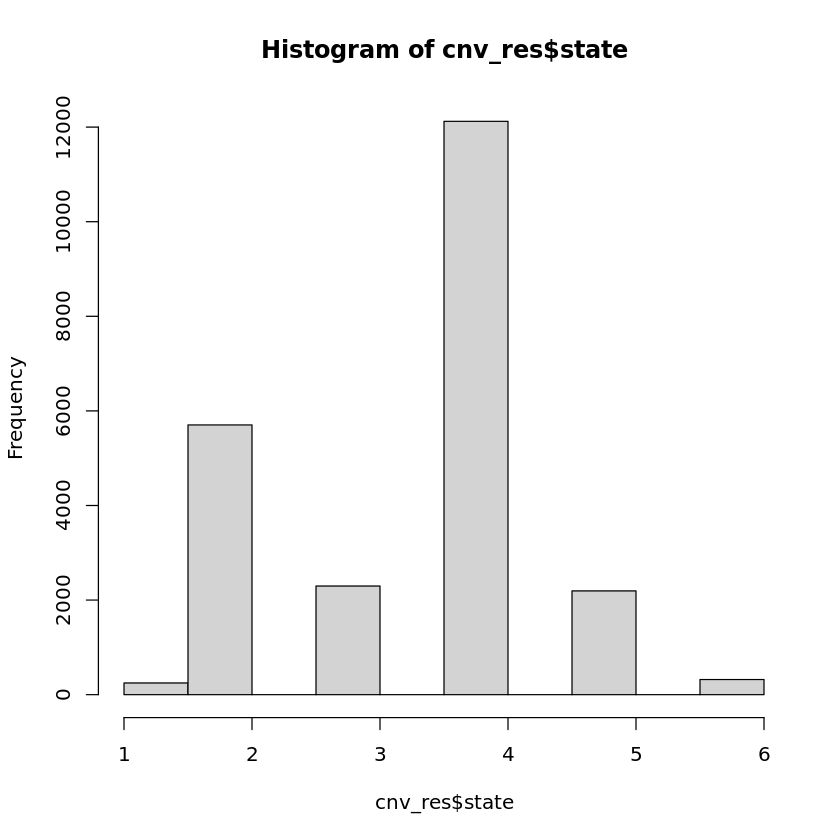

In [14]:
hist(cnv_res$state)


In [16]:
table(cnv_res$state)


    1     2     3     4     5     6 
  247  5703  2297 12122  2194   320 

In [24]:
cnv_res %>% filter(grepl("malignant_MM-1.malignant_MM-1", cell_group_name)) %>% select(gene_region_name, state) %>% unique()

gene_region_name,state
<chr>,<dbl>
1-region_99,2
1-region_101,3
1-region_102,5
1-region_103,6
1-region_104,5
2-region_105,3
2-region_107,2
2-region_108,1
2-region_109,2
